# Final Analysis

Now that we have cleaned, filtered and preprocessed our data, we can proceed to analyse it to see whether any conclusions can be drawn from the found matches.

This will be done in two parts:

First, we check whether any of the addresses, if present, of the shell companies is near the headquarter location of the charity it matches against.

Secondly, we will create graphs of all the found shell companies to analyse their distribution in the leaked papers.

__Note that in order to connect nodes to each other, both these points rest on substantial preprocessing done in the "Connections" notebook, which can be consulted for a better understanding of the structures being dealt with.__

In [1]:
#Imports
import pandas as pd

#Spark
import findspark
#findspark.init(r"C:\Users\Lucas\Desktop\ADA\spark-2.3.2-bin-hadoop2.7")
findspark.init('/opt/spark/spark-2.3.2-bin-hadoop2.7/')

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min
from pyspark.sql.functions import udf
from pyspark.sql.functions import split
from pyspark.sql.functions import explode

from pyspark.sql.types import StringType
from pyspark.sql.types import TimestampType

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()


#imports
import networkx as nx

from operator import itemgetter
import collections
from community import community_louvain
from networkx.algorithms.community.centrality import girvan_newman
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Addresses

Our goal is to find addresses connected to shell companies and see if the match the headquarters of the charity. This could be seen as a red flag that the shell company indeed represents the charity it was matched with.

In [2]:
#We can reuse the filtering functions from earlier, this time looking specifically 
#for edges of type "address" connected to nodes of type entity

def filter_edges(edges, nodes):
    '''Given a set of nodes, returns the edges connected to those nodes'''
    
    entity_ids = nodes.map(lambda r: r[0]).collect()
    
    return edges.filter(lambda r: r[0] in entity_ids or r[2] in entity_ids)

def filter_nodes(nodes, edges):
    '''Given a set of edges, return the nodes connected to those edges'''
    
    start_ids = edges.map(lambda r: r[0]).collect()
   
    end_ids = edges.map(lambda r: r[2]).collect()
    
    return nodes.rdd.filter(lambda r: r[0] in start_ids or r[0] in end_ids)

In [3]:
def get_address_matches(leak):
    '''return the match node id of first level connection with registered address '''
    
    #return the path of edges csv file
    edges = spark.read.csv('../data/'+ leak + '/*.edges.csv', header=True)
    
    #return the path of address nodes csv file
    address_nodes = spark.read.csv('../data/' + leak + '/*address.csv', header=True)
    
    #filter the edges that contain a registered address
    address_edges = edges.rdd.filter(lambda r: r[1] == 'registered_address')
    
    #get the matches 
    matches= spark.read.csv('../generated/map/connections/entity/entity_' + leak + '_matches.csv', 
                            header=True).drop('_c0')
    
    #filter the edges connected to matches
    entity_address_edges = filter_edges(address_edges, matches.rdd)
    
    #filter thes nodes linked to these edges
    leak_address = filter_nodes(address_nodes,entity_address_edges)
    

    ''' Conversion of the spark dataframe in pandas ones : '''
    
    #for the matches :
    matches_pd = pd.DataFrame(matches.collect(), 
                              columns=["node_id","ShellName","CharityName","CharityHeadquarters"])
    
    matches_pd = matches_pd[matches_pd['CharityHeadquarters'].isnull() == False]
    
    #for the nodes connected to the matches :
    address_pd = pd.DataFrame(leak_address.collect(),
                            columns = ["node_id","name","address","country_codes","countries",
                                       "sourceID","valid_until","note"])
    
    #for the edges connected to the matches :
    entity_address_edges_pd = pd.DataFrame(entity_address_edges.collect(),
                            columns = ["node_id","TYPE","END_ID","link","start_date",
                                       "end_date","sourceID","valid_until"])
    
    '''Apply 'int' type to the columns used for the merge : '''
    
    
    #rename the column adequatly for merging
    address_pd.rename(columns = {'node_id':'END_ID'}, inplace=True)
    
    #drop unusefull columns in order to avoid conflict when merging
    address_pd.drop(['note','valid_until','sourceID'],axis = 1, inplace = True)
    
    #first we merge in order to obtain correspondance between the matches and 
    #the corresponding edges with registered adress
    maches_edges = matches_pd.merge(entity_address_edges_pd, on = 'node_id')
    
    #then to node linked to these edges
    matches_nodes = maches_edges.merge(address_pd, on = 'END_ID')

    return matches_nodes

In [4]:

leaks = ['panama', 'paradise', 'offshore', 'bahamas']
address_dfs = {}

print('number of address pairs found:')
for leak in leaks:
    address_df = get_address_matches(leak)
    print(leak +': ' + str(len(address_df)))
    address_dfs[leak] = address_df[['ShellName', 'CharityName', 
                                    'CharityHeadquarters', 'address', 'countries']]


number of address pairs found:
panama: 0
paradise: 14
offshore: 0
bahamas: 0


In [5]:
address_dfs['panama']

Empty DataFrame
Columns: [ShellName, CharityName, CharityHeadquarters, address, countries]
Index: []

In [6]:
address_dfs['paradise']

ShellName  \
0          Memorial Sloan-Kettering Cancer Center   
1                     Goodwill Industries Captive   
2                                     Mayo Clinic   
3          Memorial Sloan-Kettering Cancer Center   
4                          The Nature Conservancy   
5   The Rotary Foundation of Rotary International   
6                      World Vision International   
7                                      Young Life   
8                         American Cancer Society   
9                                            SPCA   
10                 The Metropolitan Museum of Art   
11                            WORLD WILDLIFE FUND   
12                        STICHTING JE FOUNDATION   
13                   STICHTING MICKY'S FOUNDATION   

                                  CharityName  \
0      Memorial Sloan Kettering Cancer Center   
1           Goodwill Industries International   
2                                 Mayo Clinic   
3      Memorial Sloan Kettering Cancer Center   
4                          Nature Conservancy   
5   Rotary Foundation of Rotary International   
6                                World Vision   
7                                  Young Life   
8                     American Cancer Society   
9                               American SPCA   
10                 Metropolitan Museum of Art   
11                        World Wildlife Fund   
12                 Stichting INGKA Foundation   
13                 Stichting INGKA Foundation   

                 CharityHeadquarters                              address  \
0                 New York, New York          633 Third Avenue, 4th Floor   
1                Rockville, Maryland                     c/o David Becker   
2               Rochester, Minnesota                c/o Treasury Services   
3                 New York, New York    405 Lexington Avenue, Third Floor   
4                Arlington, Virginia  4245 North Fairfax Drive, Suite 100   
5                 Evanston, Illinois                    One Rotary Center   
6            Federal Way, Washington          800 W Chestnut Ave., M/#704   
7         Colorado Springs, Colorado                          P O Box 520   
8                   Atlanta, Georgia                       225 N Michigan   
9                 New York, New York                       32 Valley Road   
10                New York, New York                    1000 Fifth Avenue   
11  Washington, District of Columbia          3rd Floor, 2431 – 37 Ave NE   
12                     Liechtenstein                                 None   
13                     Liechtenstein                                 None   

        countries  
0   United States  
1   United States  
2   United States  
3   United States  
4   United States  
5   United States  
6   United States  
7   United States  
8   United States  
9         Bermuda  
10  United States  
11         Canada  
12          Aruba  
13          Aruba

## Graphs

Using the previously collected data detailing how matches connect to the rest of the leaked information, we can create graphs and see the degree of interconnectivity between the matches.

We only use degree 1, as larger degrees resulted in unmanagably large graphs. But distance 1 is quite good enough for our purposes.

In [7]:
#Global variables 

DEGREE = 1

DEGREE_FILE = '../generated/map/degree_' + str(DEGREE) +'/'

def get_graph_elem_file(elem_type, leak):
    return DEGREE_FILE + leak + '_' + elem_type + '.csv'

### Create the graphs

Note that as some of the graphs have still very many nodes, we can choose to filter these down to only those connected to more than one node (unless a node is a match -- we still want to know who is not connected to anyone).

Note the special attention drawn to the "bahamas" leak, which has a slightly different schema.

In [8]:
def remove_loners(full_df, clusters_only, cluster_size=2):
    
    '''Removes nodes with fewer than 2 connections who are not matches'''
    
    node_counts = full_df['START_ID'].append(full_df['END_ID']).value_counts()

    ids_to_remove = []
        
    for index, row in full_df.iterrows():
        start_id = row['START_ID']
        end_id = row['END_ID']
        
        if clusters_only:
            if ((node_counts[start_id] < cluster_size) and (node_counts[end_id] < cluster_size)):
                ids_to_remove.append(index)
            
        else:
            if ((row['match_x'] == False and node_counts[start_id] < cluster_size)
                or (row['match_y'] == False and node_counts[end_id] < cluster_size)):
                ids_to_remove.append(index)
    
    return full_df.drop(full_df.index[ids_to_remove]).reset_index(drop=True)

def graph_leak_matches(leak, dense=False, clusters_only=False, cluster_size=2):
    
    '''Creates graphs of matches found in a given leak'''
    
    bahamas = (leak == 'bahamas')

    node_id = '0'
    name_index = '1'

    if bahamas:
        node_id = '4' 
        name_index = '7'

    plt.rcParams["figure.figsize"] = (23,23)

    
    #Load the data
    nodes = pd.read_csv(get_graph_elem_file('nodes', leak), index_col=0)\
                                                            .reset_index(drop=True)[[node_id, name_index, 'Match']]

    nodes.rename(columns={node_id:'node_id', name_index:'name', 'Match':'match'}, inplace=True)
    edges = pd.read_csv(get_graph_elem_file('edges', leak), index_col=0).reset_index(drop=True)[['START_ID', 'END_ID']]

    #Format the data as a set of edges with information about the nodes
    full_df = pd.merge(nodes, edges, left_on='node_id', right_on='START_ID')
    full_df = pd.merge(full_df, nodes, left_on='END_ID', right_on='node_id').drop(['node_id_x', 'node_id_y'], axis=1)
    
    #filter too large graphs if told so
    if dense:
        print('Size before removing loners: ' + str(len(full_df)))
        full_df = remove_loners(full_df, clusters_only, cluster_size)
        print('Size after removing loners: ' + str(len(full_df)))
    
    #create the graph
    graph = nx.from_pandas_edgelist(full_df, 'name_x', 'name_y', edge_attr=None, create_using= nx.Graph())
    
    #prepare for coloring the nodes according to if it is a match to a charity or not
    match_class_1 = full_df[['name_x', 'match_x']].rename(columns={'name_x':'name', 'match_x':'match'})
    match_class_2 = full_df[['name_y', 'match_y']].rename(columns={'name_y':'name', 'match_y':'match'})
    
    match_class = match_class_1.append(match_class_2).set_index('name')
    match_class = match_class[~match_class.index.duplicated(keep='first')]
    
    match_class = match_class.reindex(graph.nodes())
    match_class['match'] = pd.Categorical(match_class['match'])
    
    print('Matches for ' + leak + ' papers: ')
    print(nx.info(graph))
    
    #draw the graph
    nx.draw(graph, nx.spring_layout(graph, scale=60, k=0.25), with_labels=True, alpha=0.7, node_size=1000,
        node_color=match_class['match'].cat.codes, cmap=plt.cm.autumn)
    

    

### Display graphs

We display two graphs for each set of leaks, one with all the nodes, and a smaller, denser one with only nodes belonging to clusters of a certain size.

Matches for panama papers: 
Name: 
Type: Graph
Number of nodes: 40
Number of edges: 26
Average degree:   1.3000
Yellow: "Charities" / Red: "Connectors"


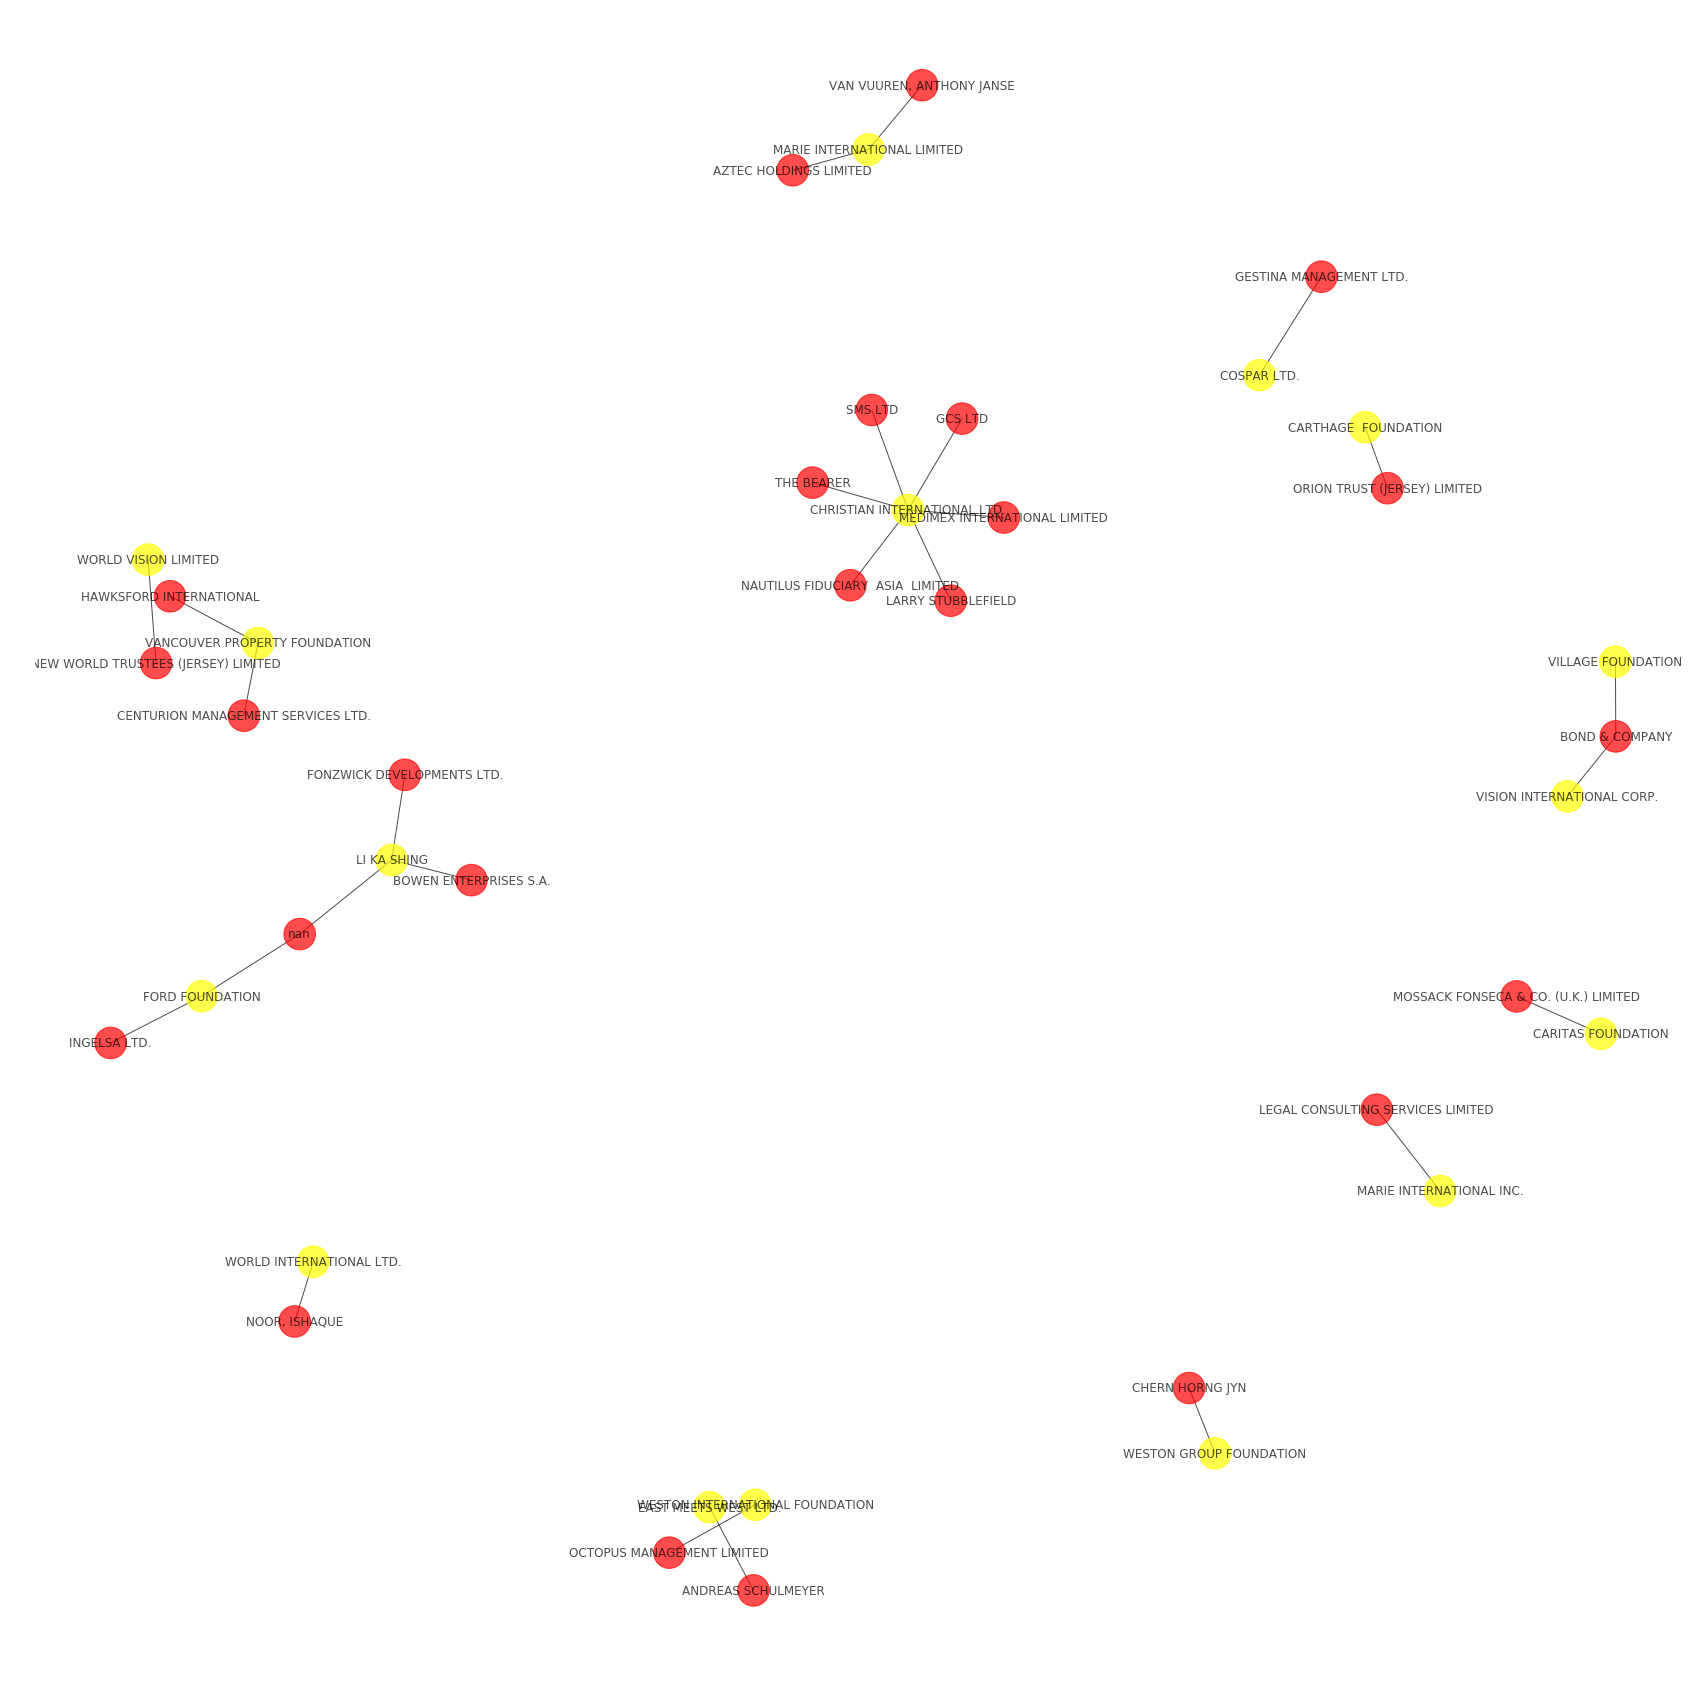

In [9]:
graph_leak_matches('panama')
print('Yellow: "Charities" / Red: "Connectors"')

Size before removing loners: 29
Size after removing loners: 6
Matches for panama papers: 
Name: 
Type: Graph
Number of nodes: 7
Number of edges: 4
Average degree:   1.1429


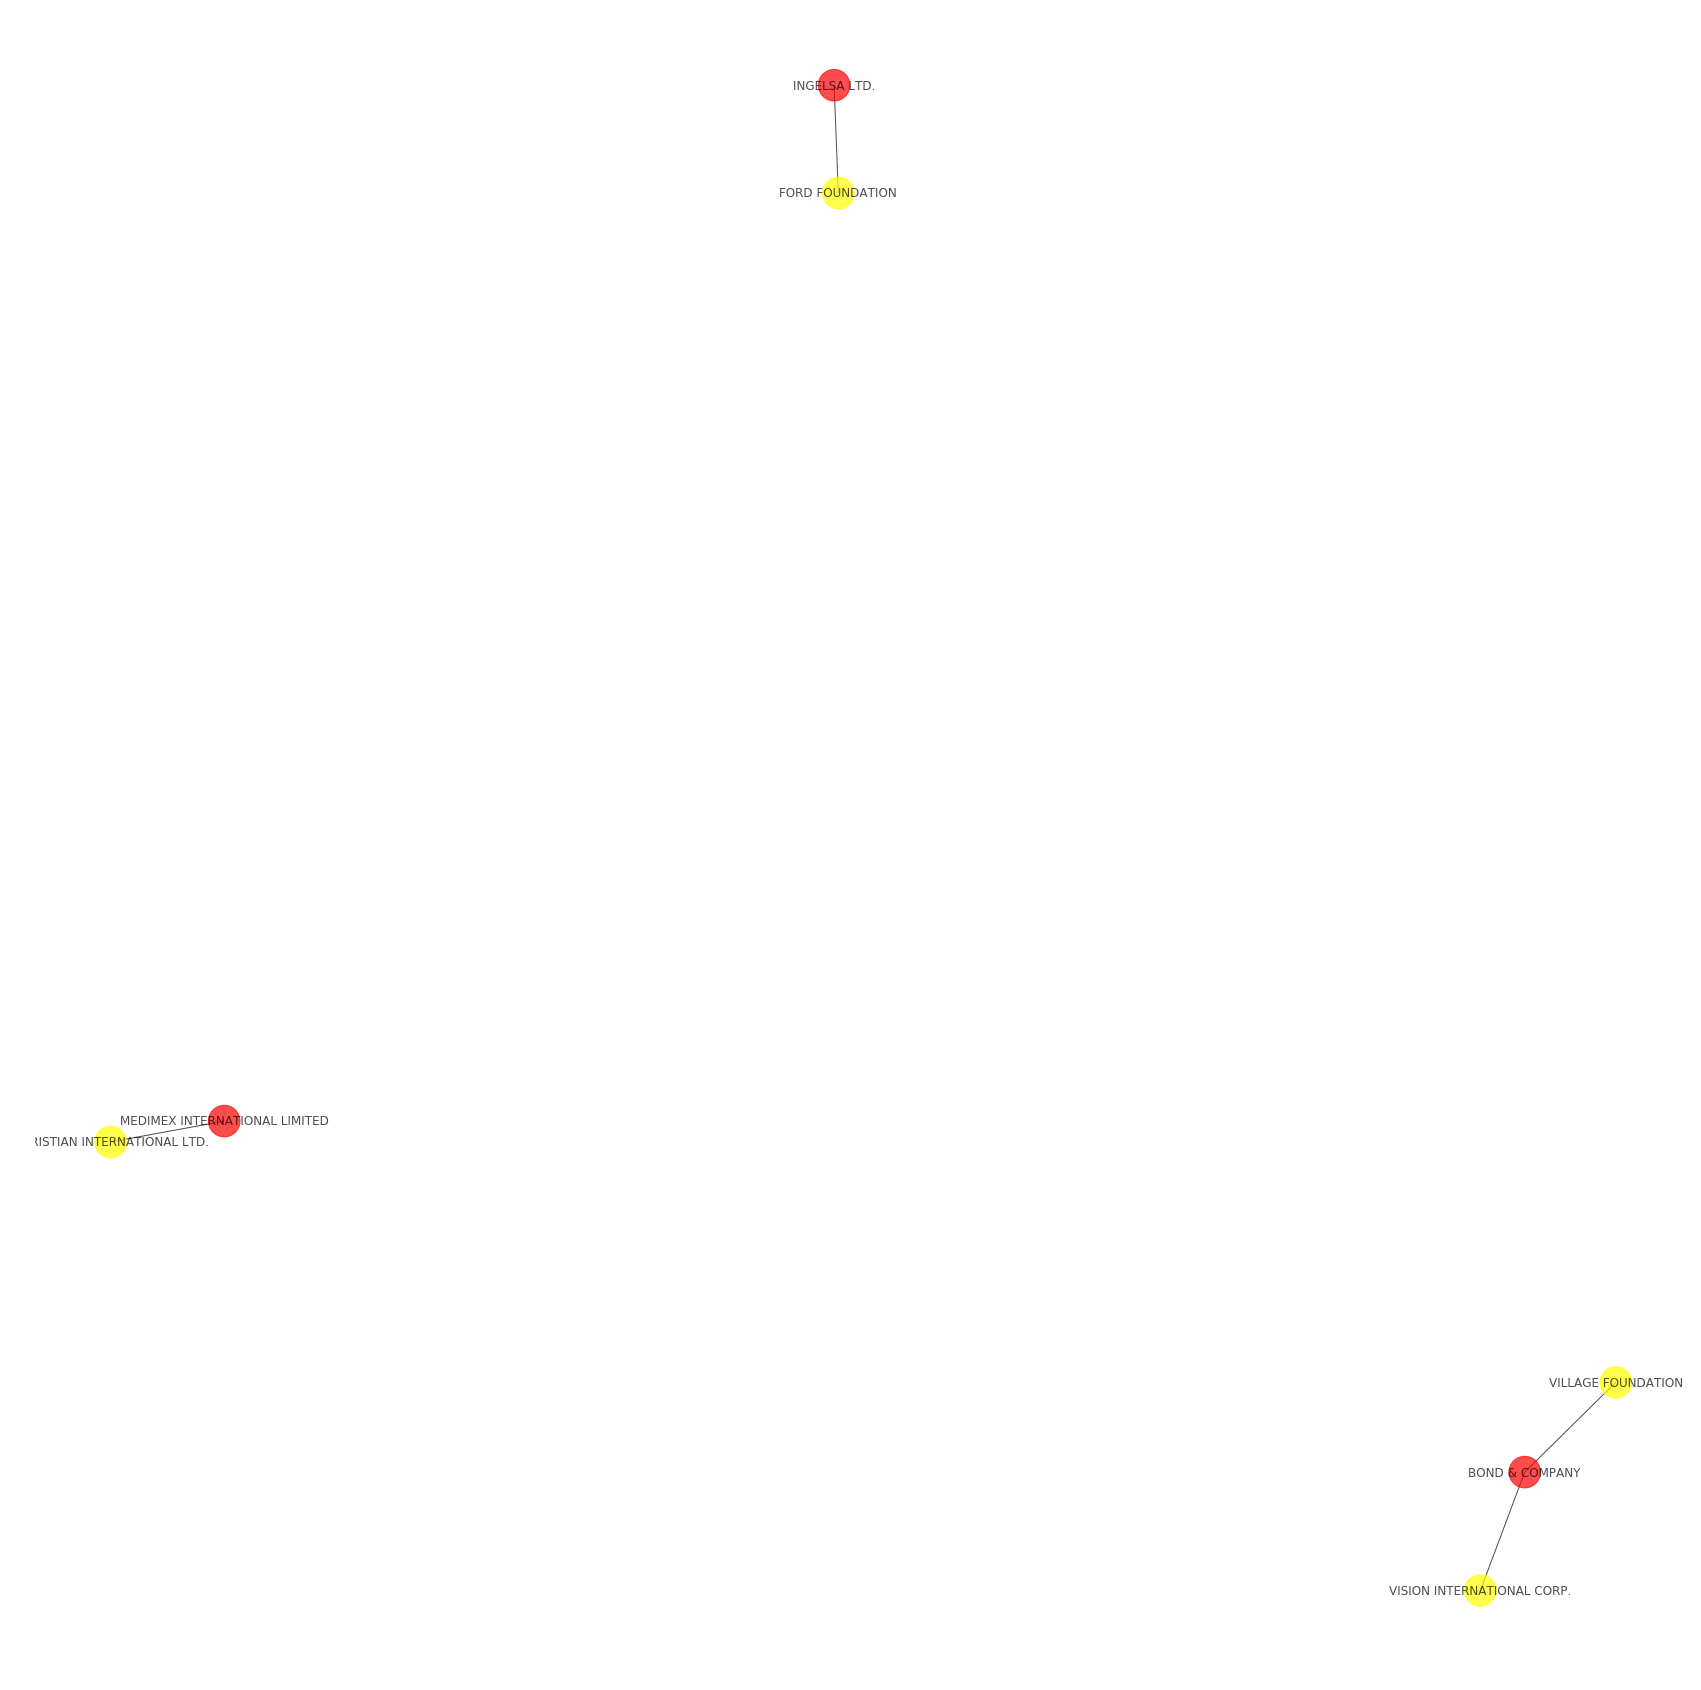

In [10]:
graph_leak_matches('panama', True)

Size before removing loners: 29
Size after removing loners: 17
Matches for panama papers: 
Name: 
Type: Graph
Number of nodes: 18
Number of edges: 14
Average degree:   1.5556


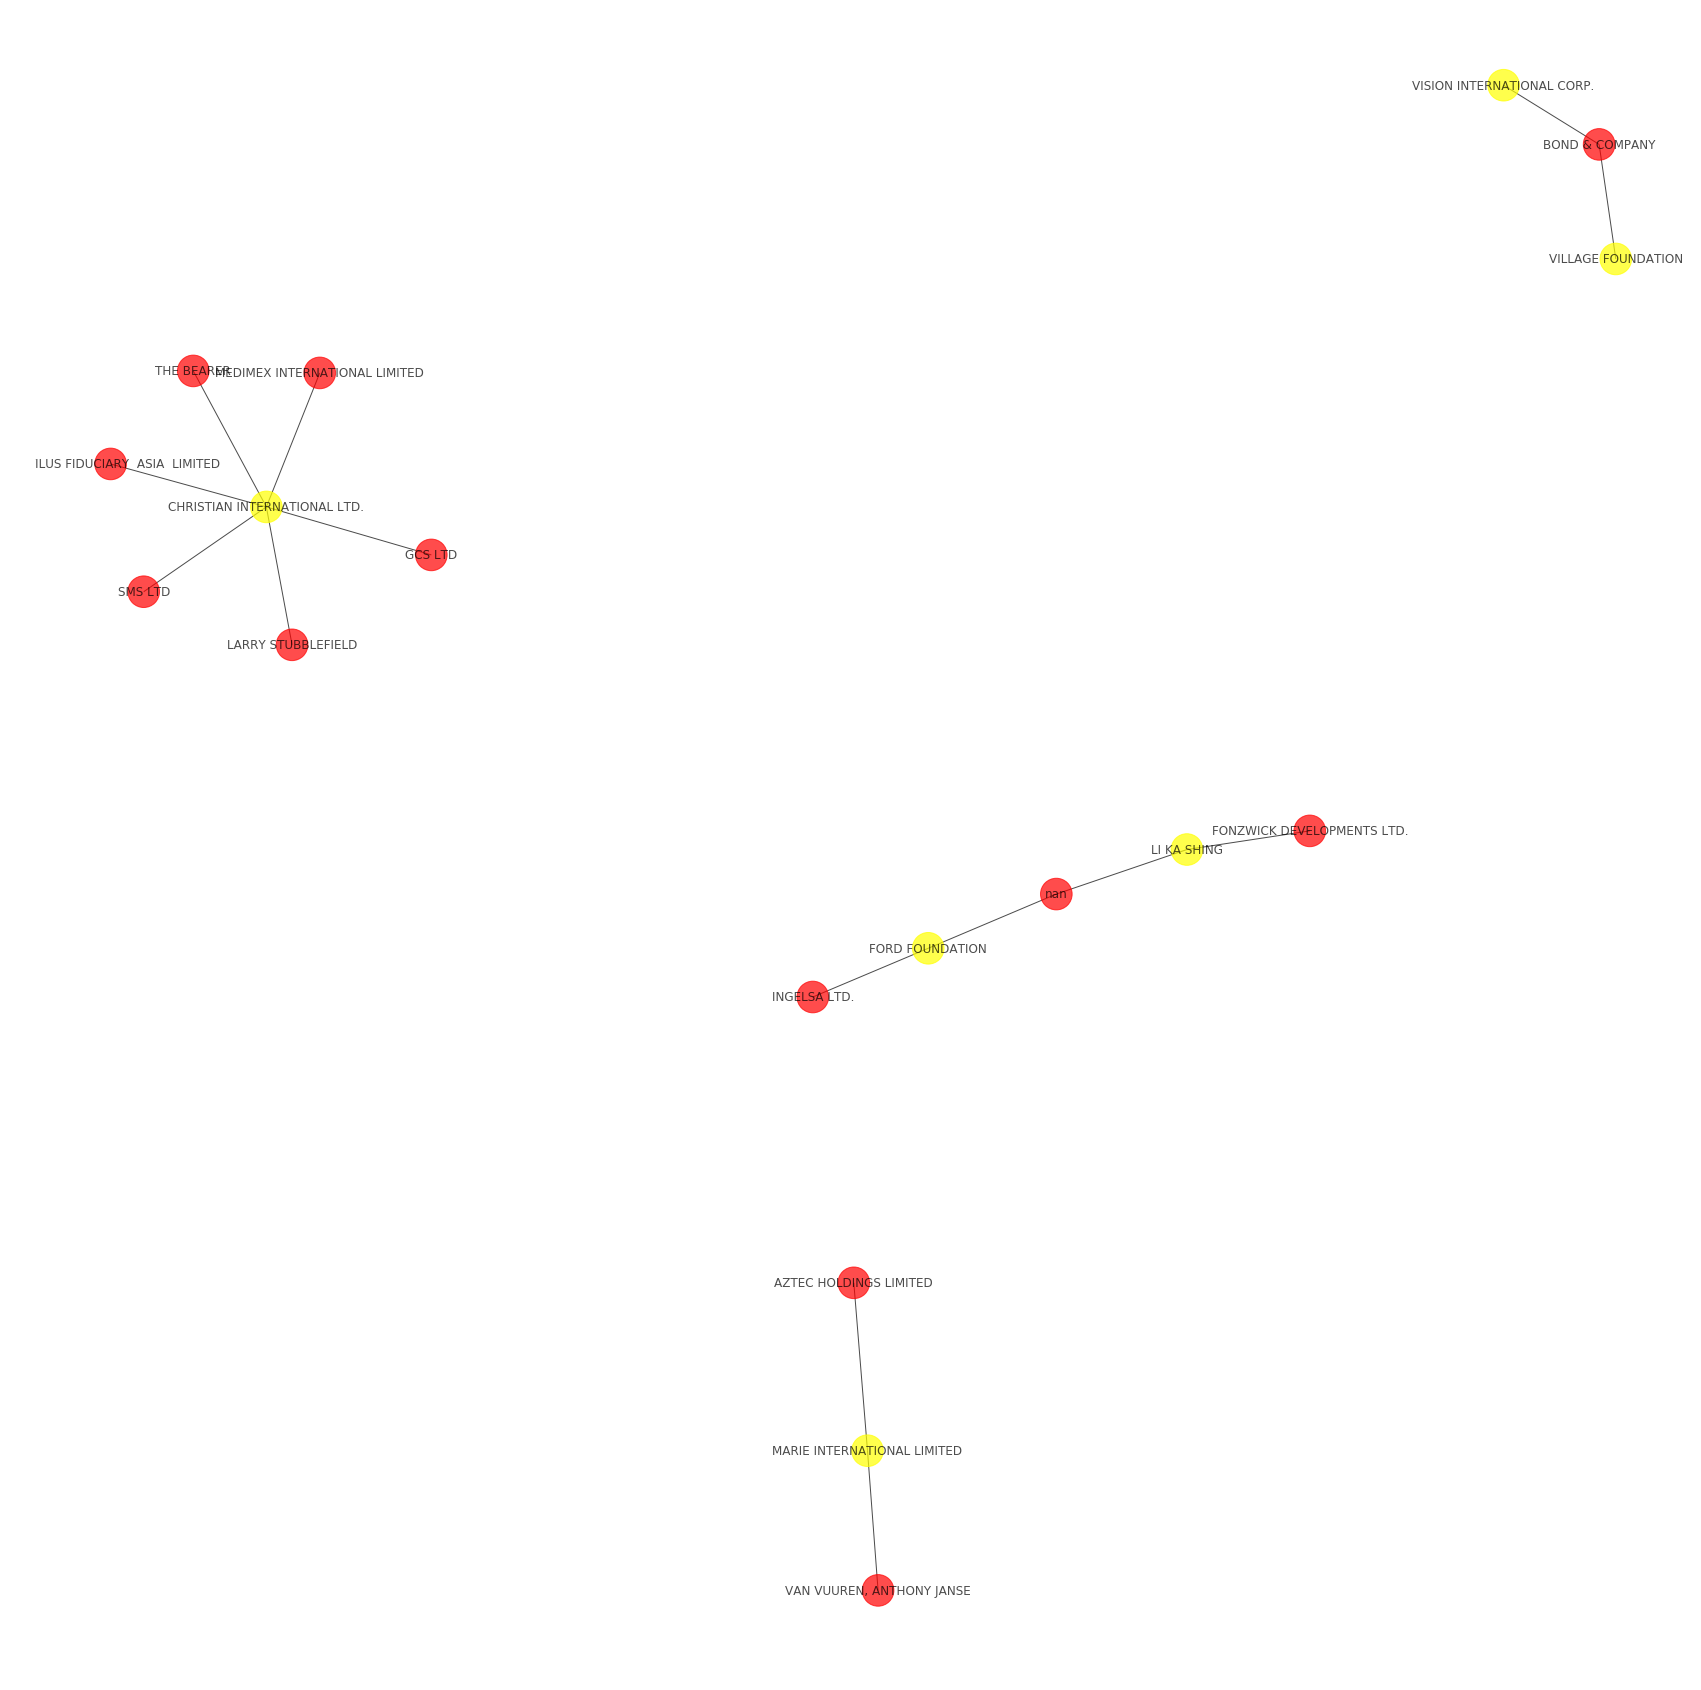

In [11]:
graph_leak_matches('panama', True, True)

Matches for paradise papers: 
Name: 
Type: Graph
Number of nodes: 210
Number of edges: 158
Average degree:   1.5048


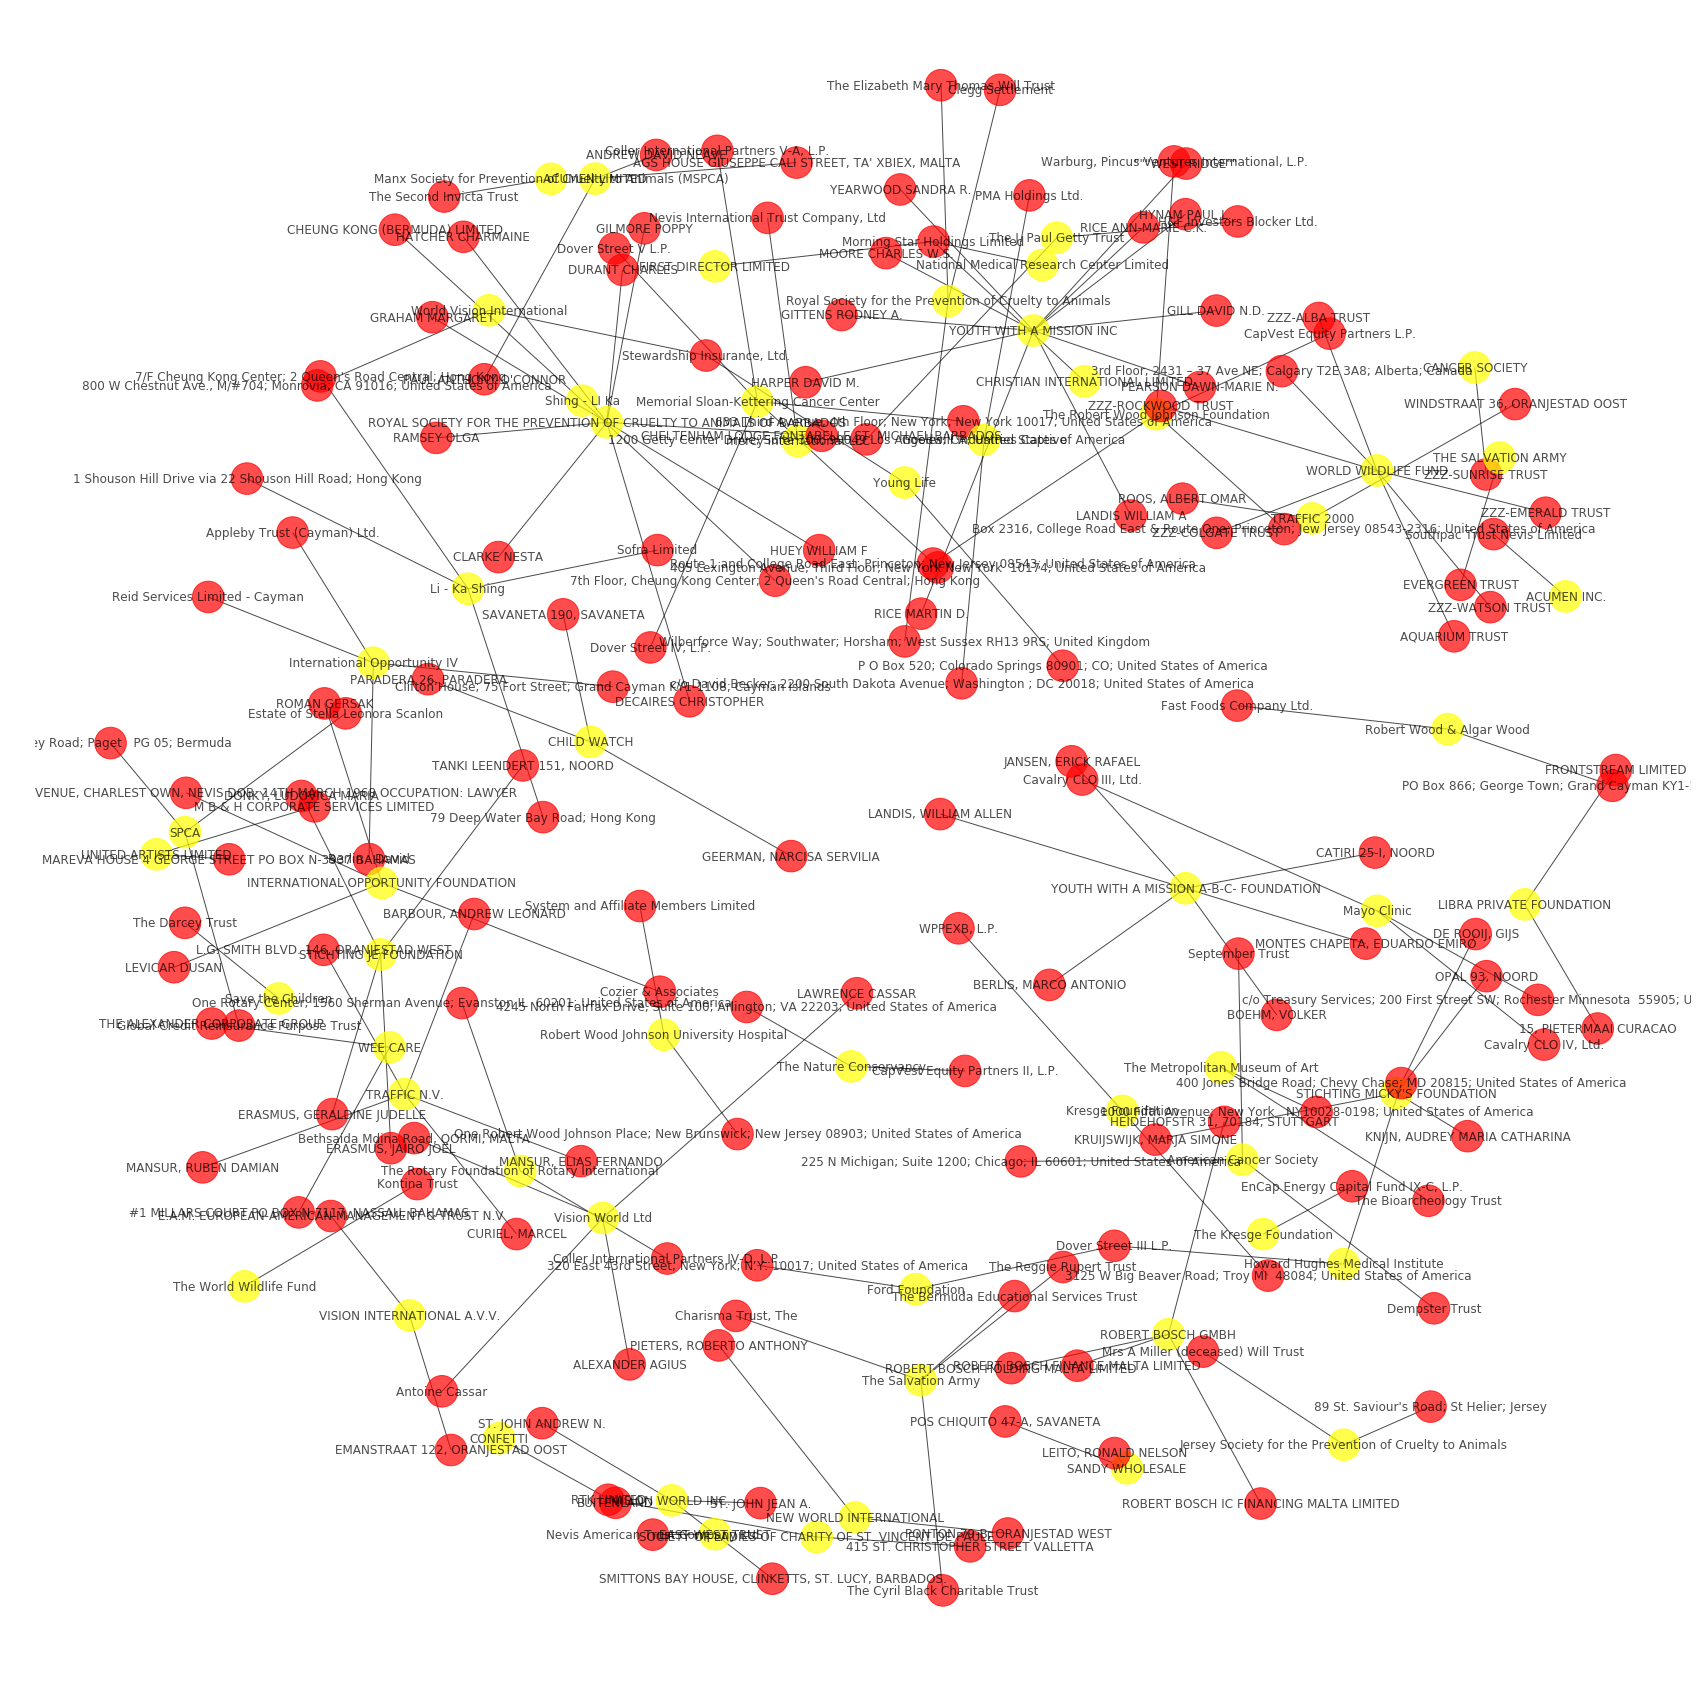

In [12]:
graph_leak_matches('paradise')

Size before removing loners: 177
Size after removing loners: 32
Matches for paradise papers: 
Name: 
Type: Graph
Number of nodes: 22
Number of edges: 15
Average degree:   1.3636


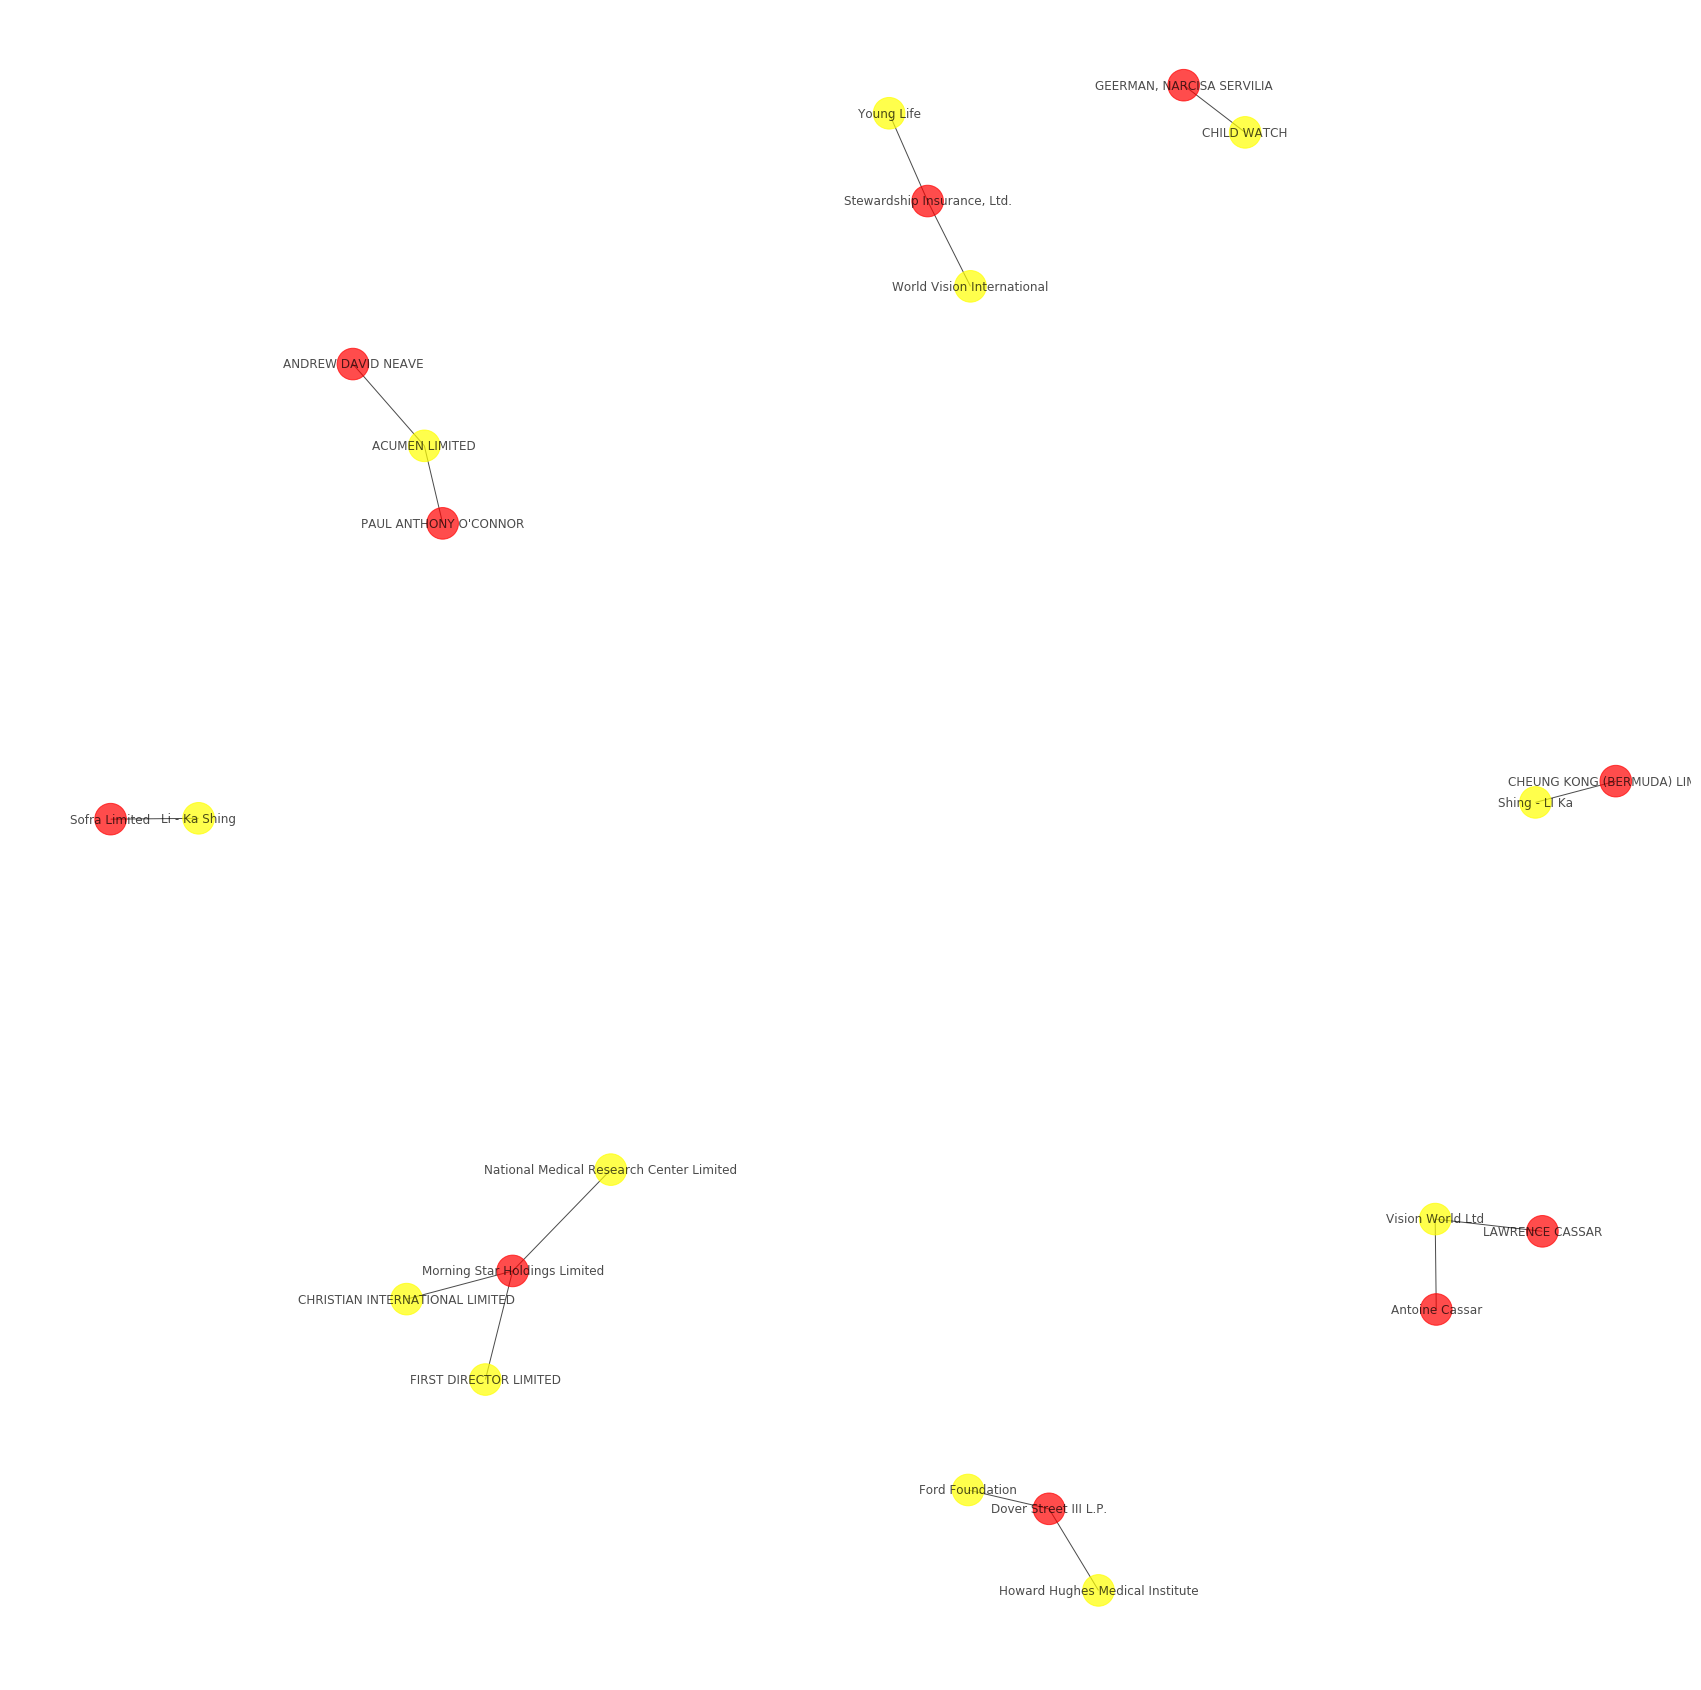

In [13]:
graph_leak_matches('paradise', True)

Size before removing loners: 177
Size after removing loners: 167
Matches for paradise papers: 
Name: 
Type: Graph
Number of nodes: 190
Number of edges: 148
Average degree:   1.5579


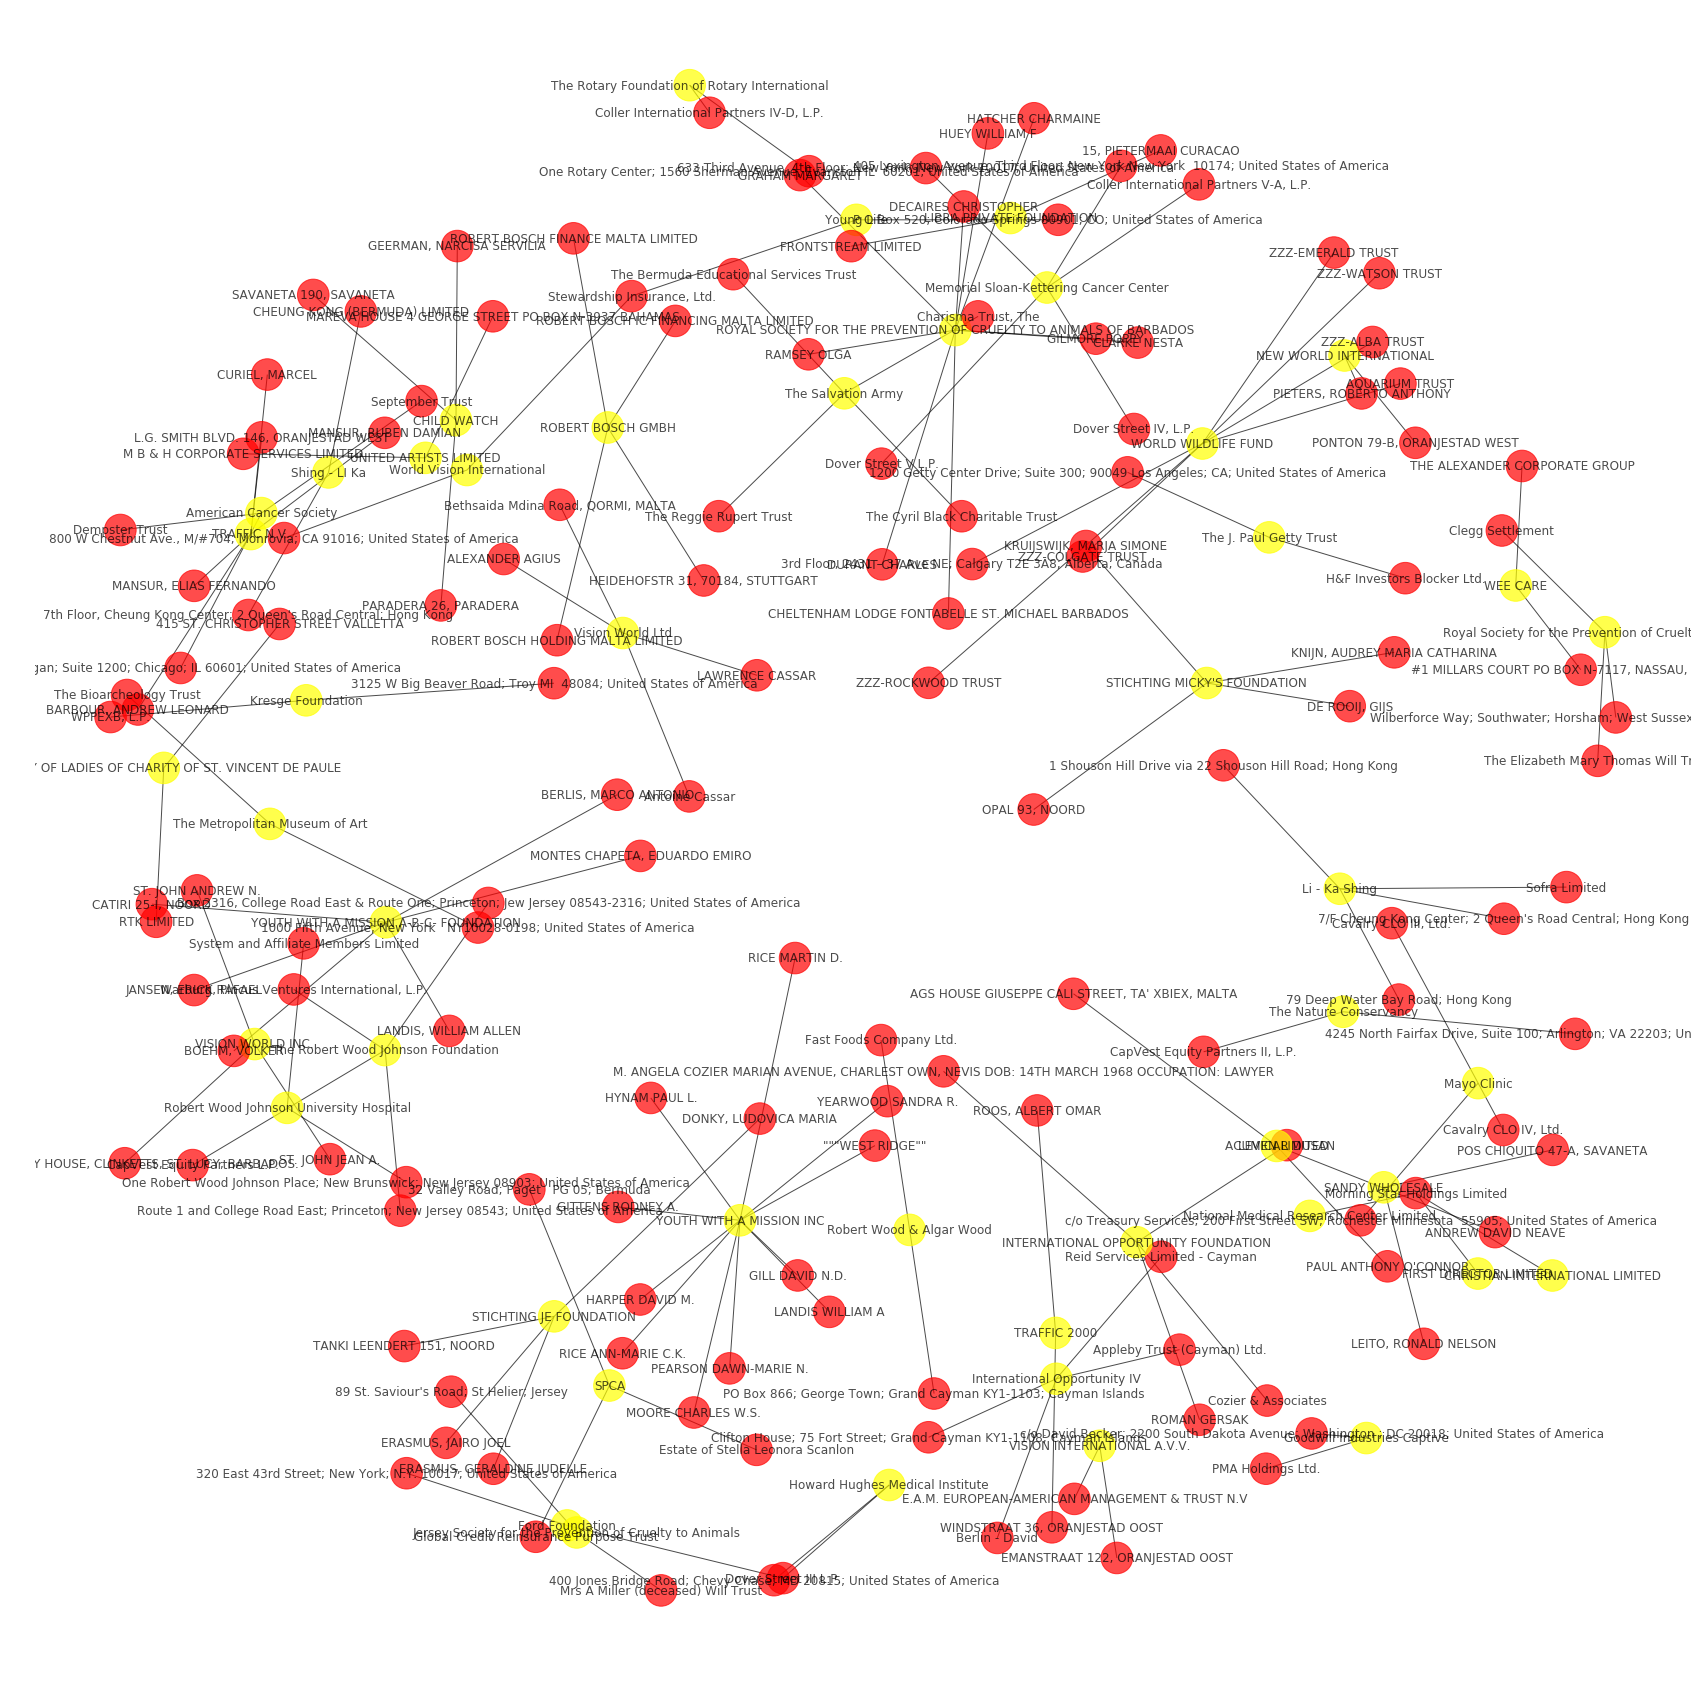

In [14]:
graph_leak_matches('paradise', True, True)

Size before removing loners: 177
Size after removing loners: 121
Matches for paradise papers: 
Name: 
Type: Graph
Number of nodes: 125
Number of edges: 102
Average degree:   1.6320


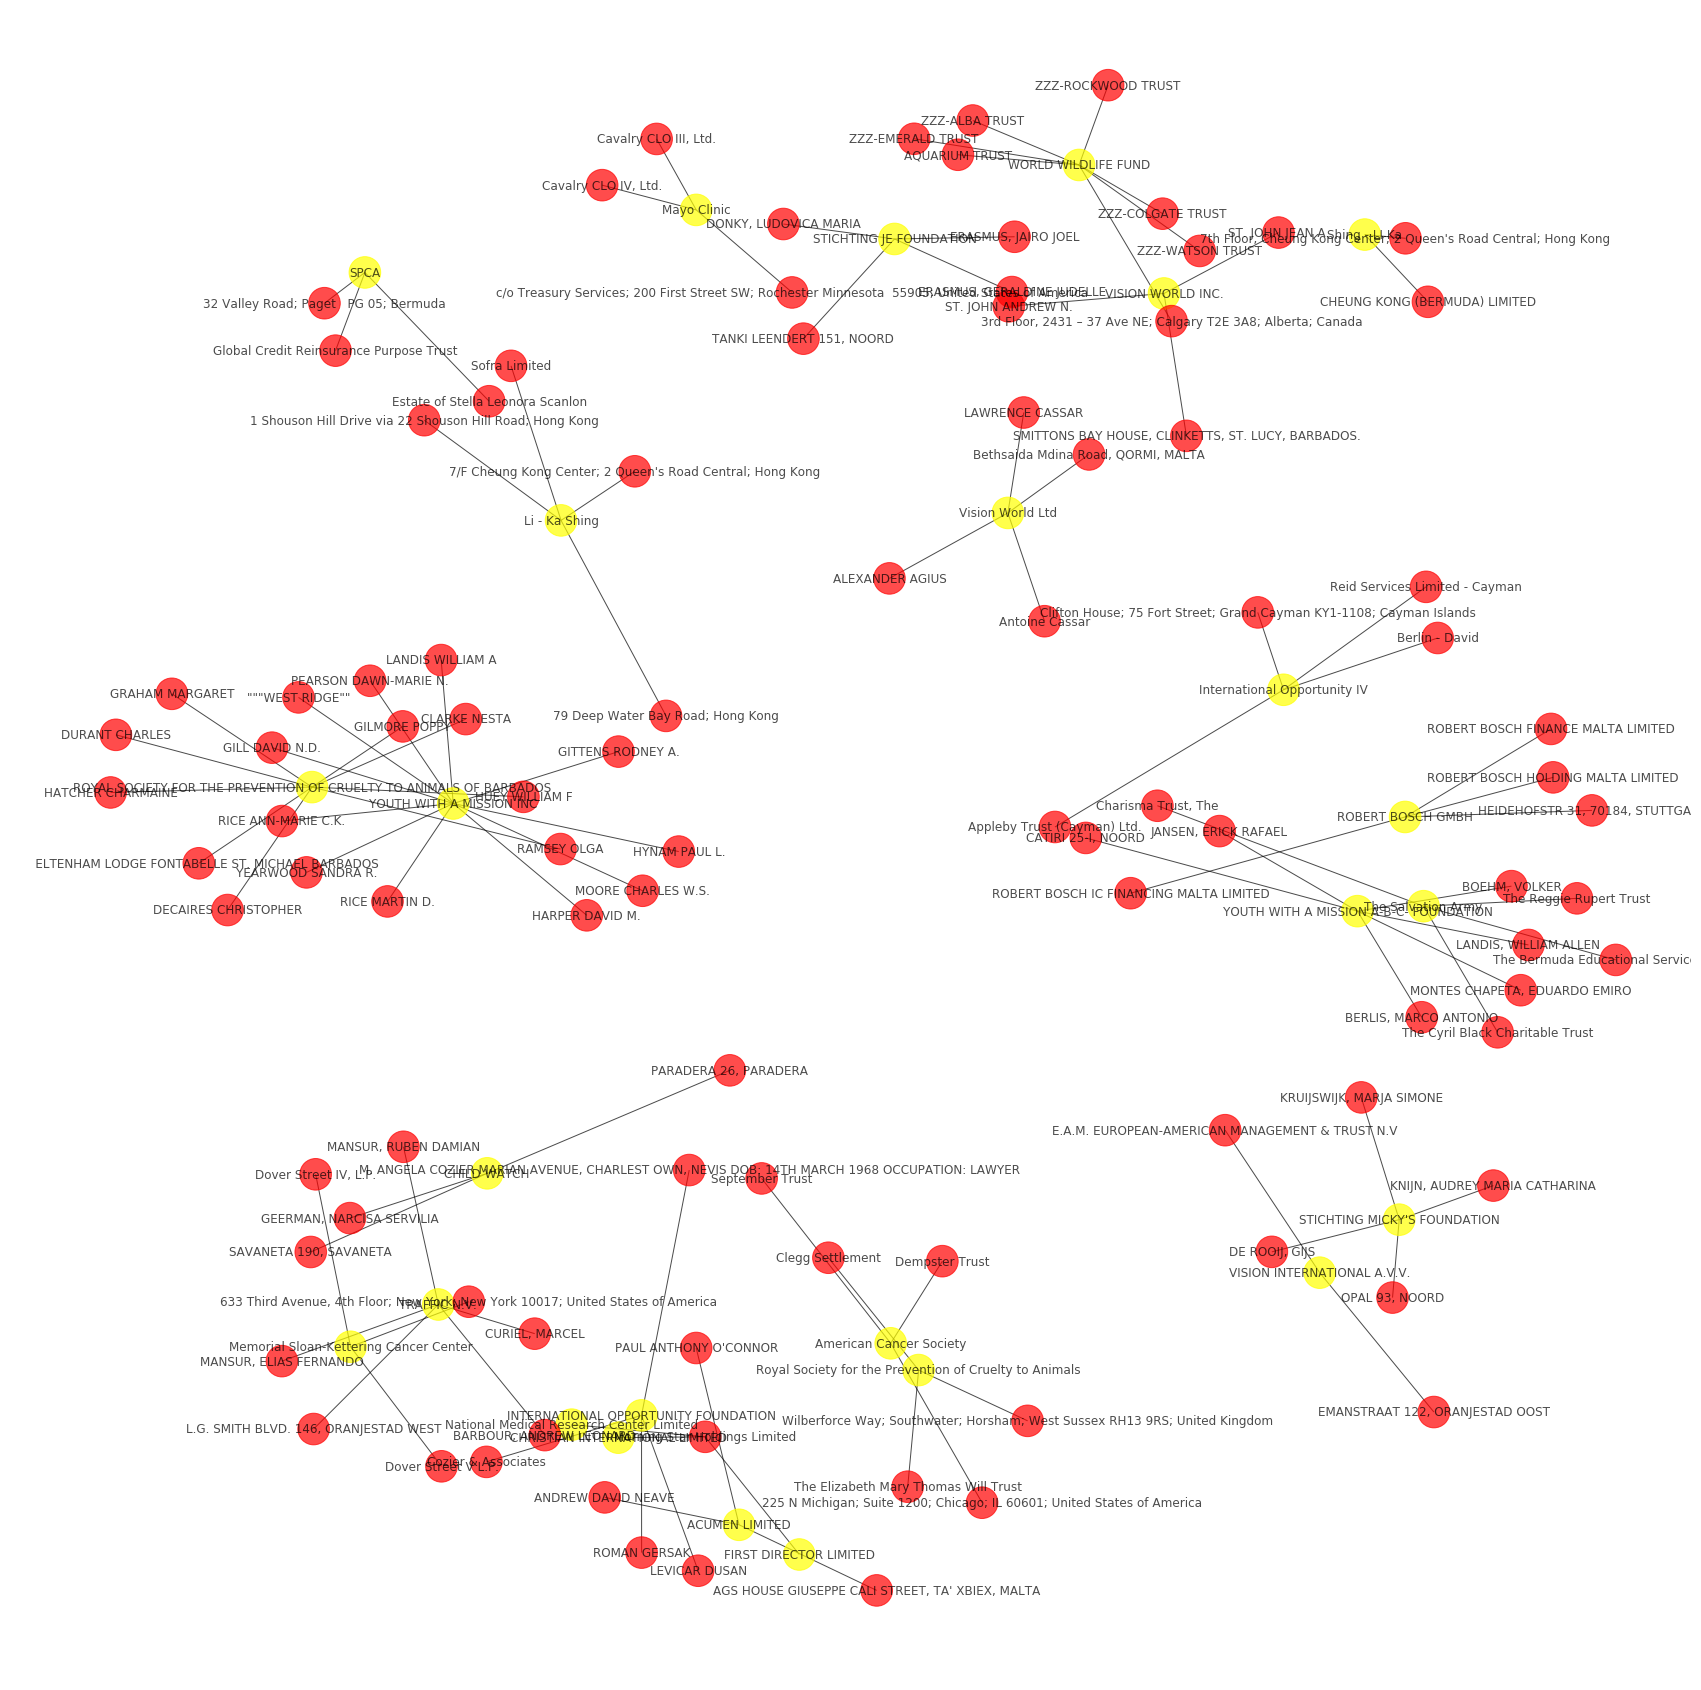

In [15]:
graph_leak_matches('paradise', True, True, 3)

Matches for offshore papers: 
Name: 
Type: Graph
Number of nodes: 67
Number of edges: 61
Average degree:   1.8209


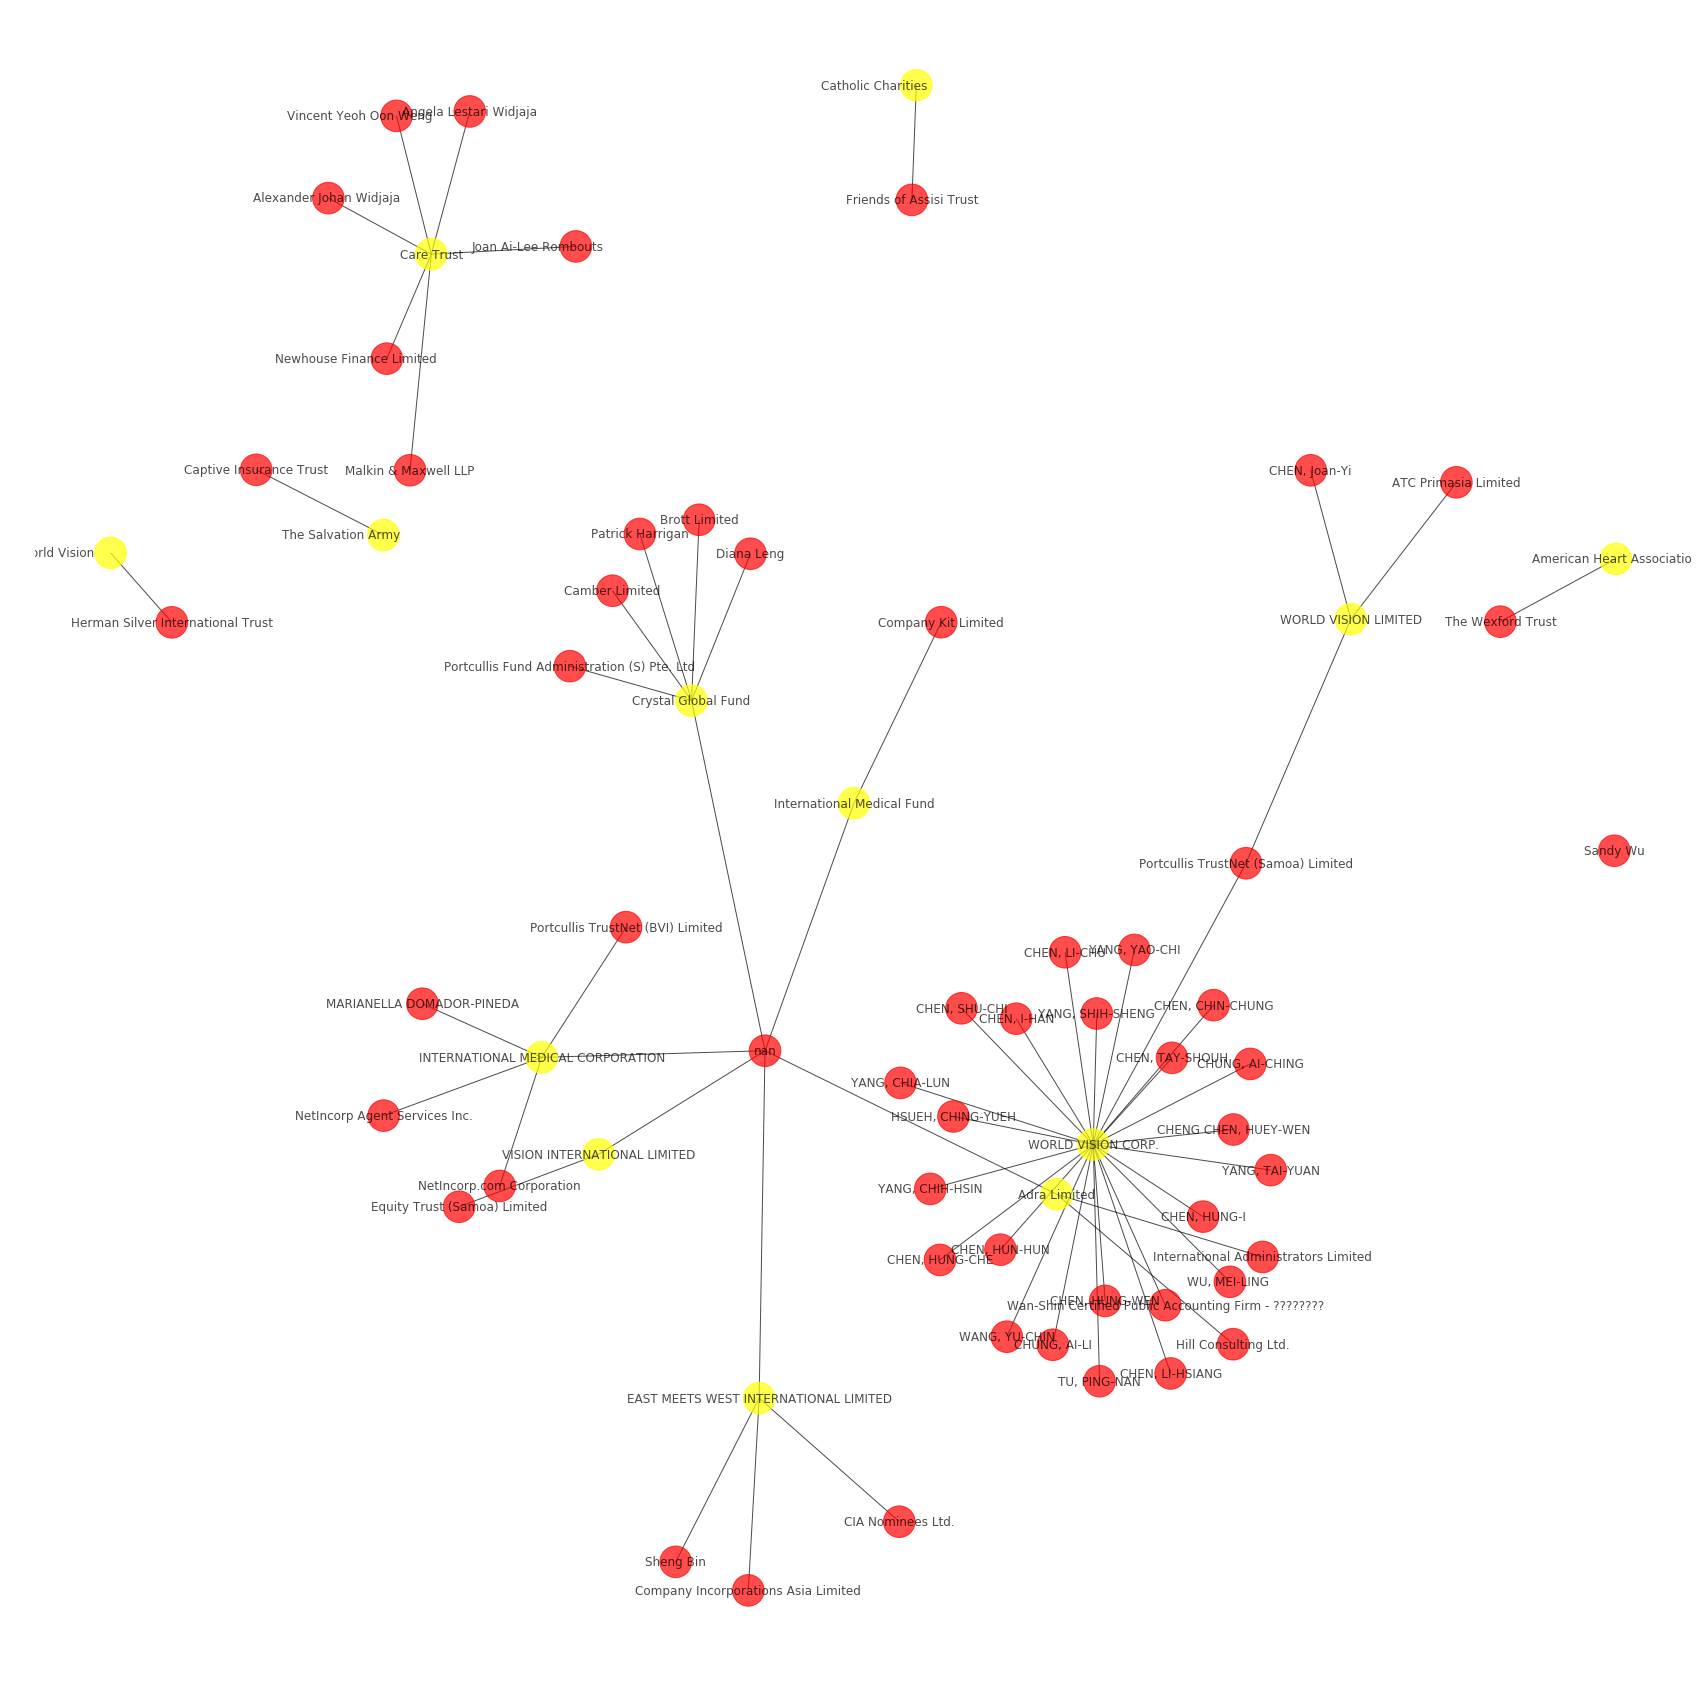

In [16]:
graph_leak_matches('offshore')

Size before removing loners: 70
Size after removing loners: 17
Matches for offshore papers: 
Name: 
Type: Graph
Number of nodes: 12
Number of edges: 8
Average degree:   1.3333


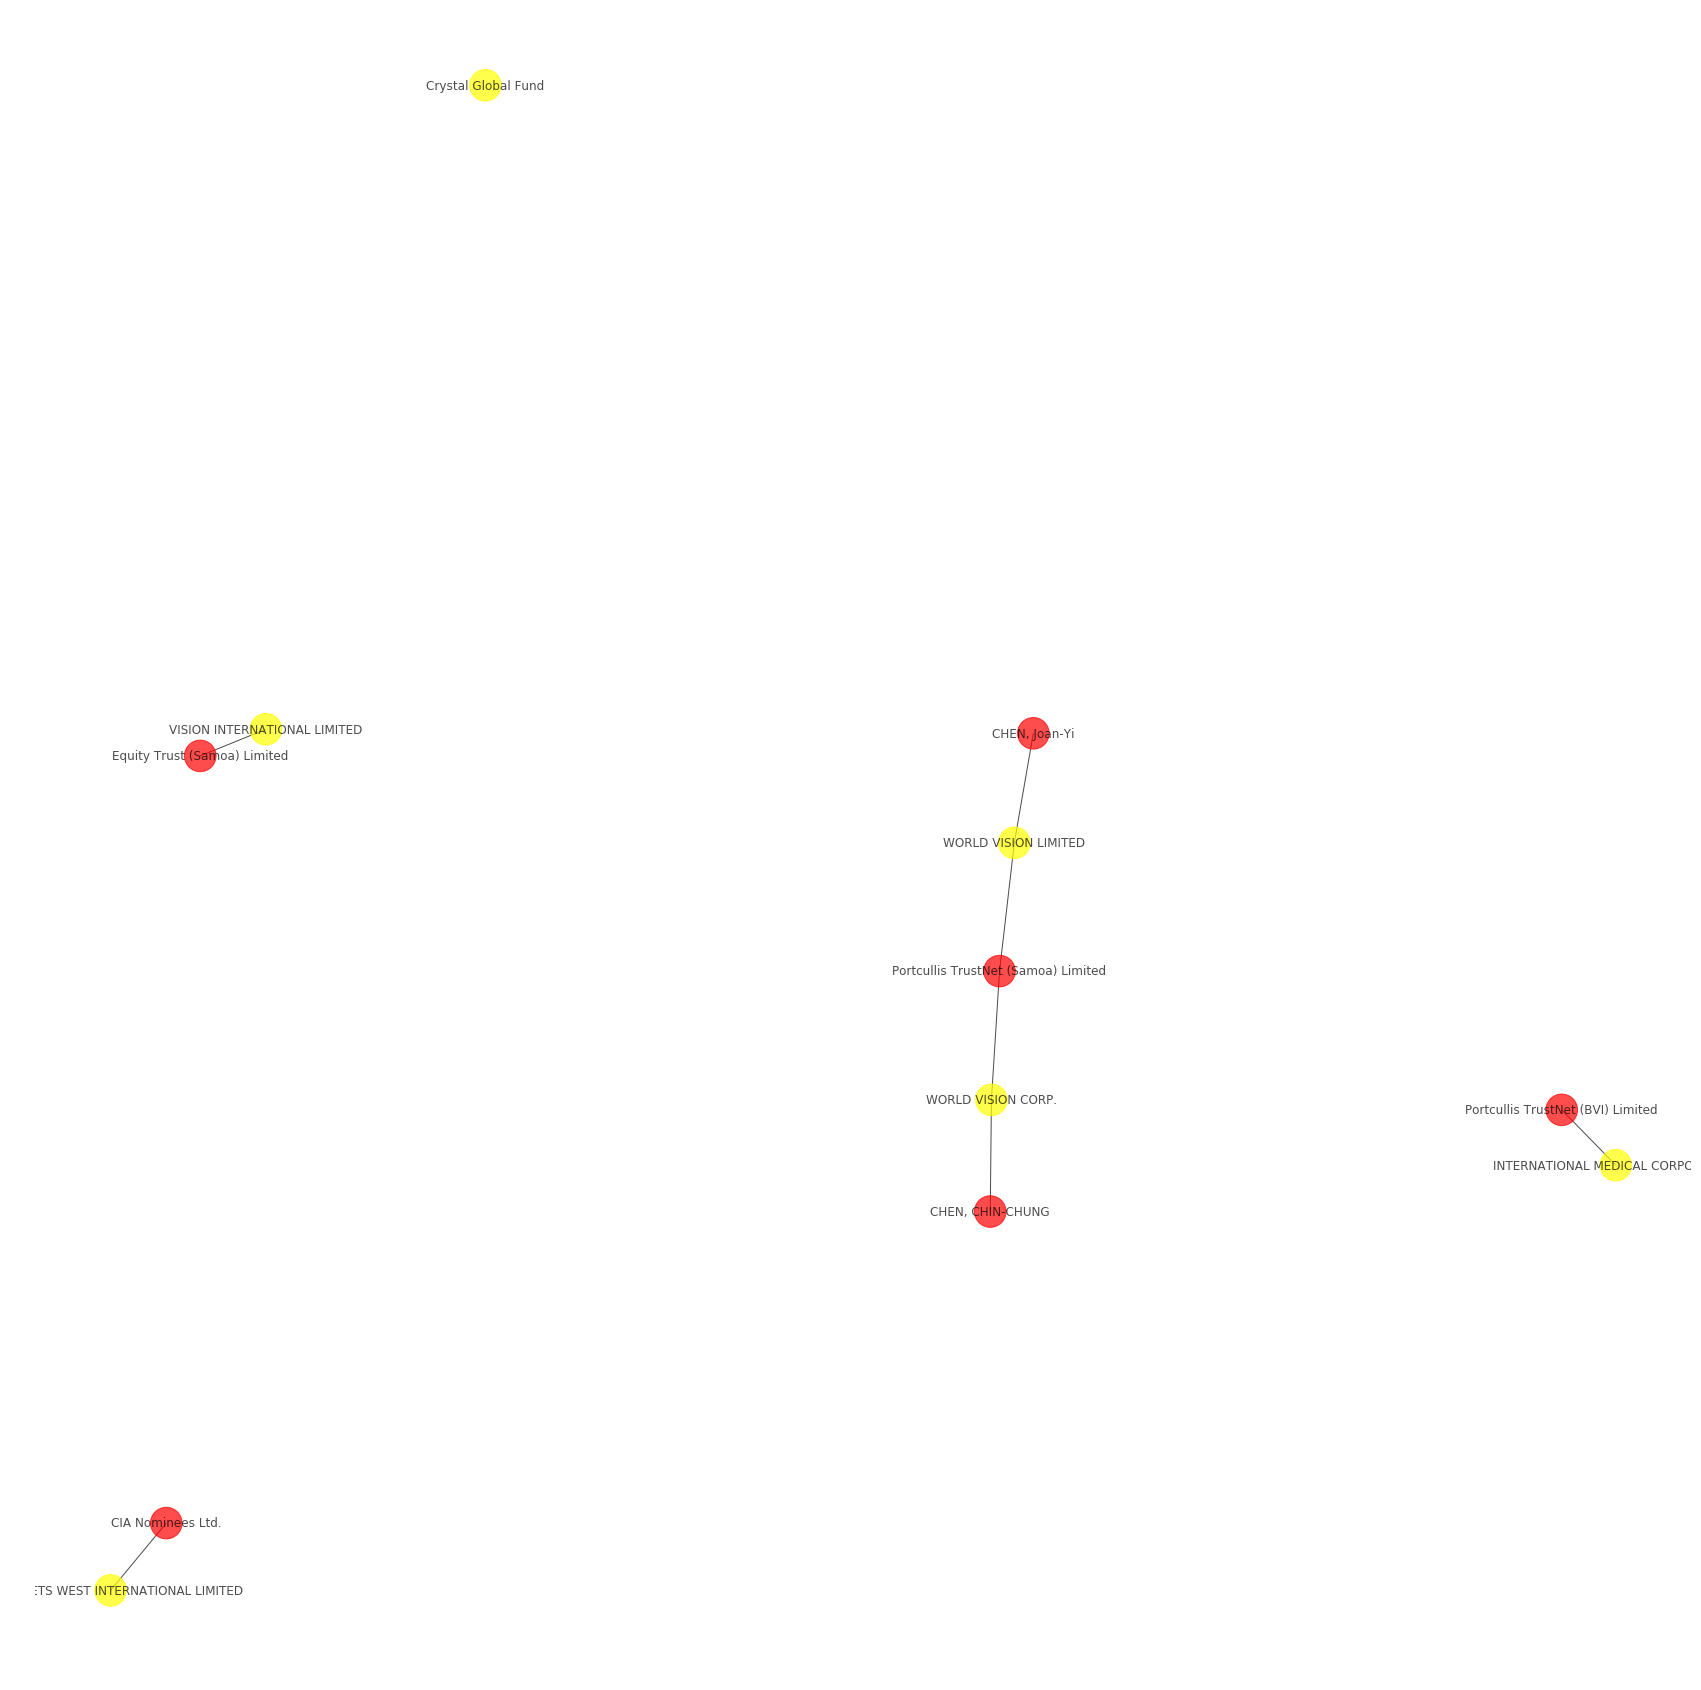

In [17]:
graph_leak_matches('offshore', True)

Size before removing loners: 70
Size after removing loners: 63
Matches for offshore papers: 
Name: 
Type: Graph
Number of nodes: 56
Number of edges: 54
Average degree:   1.9286


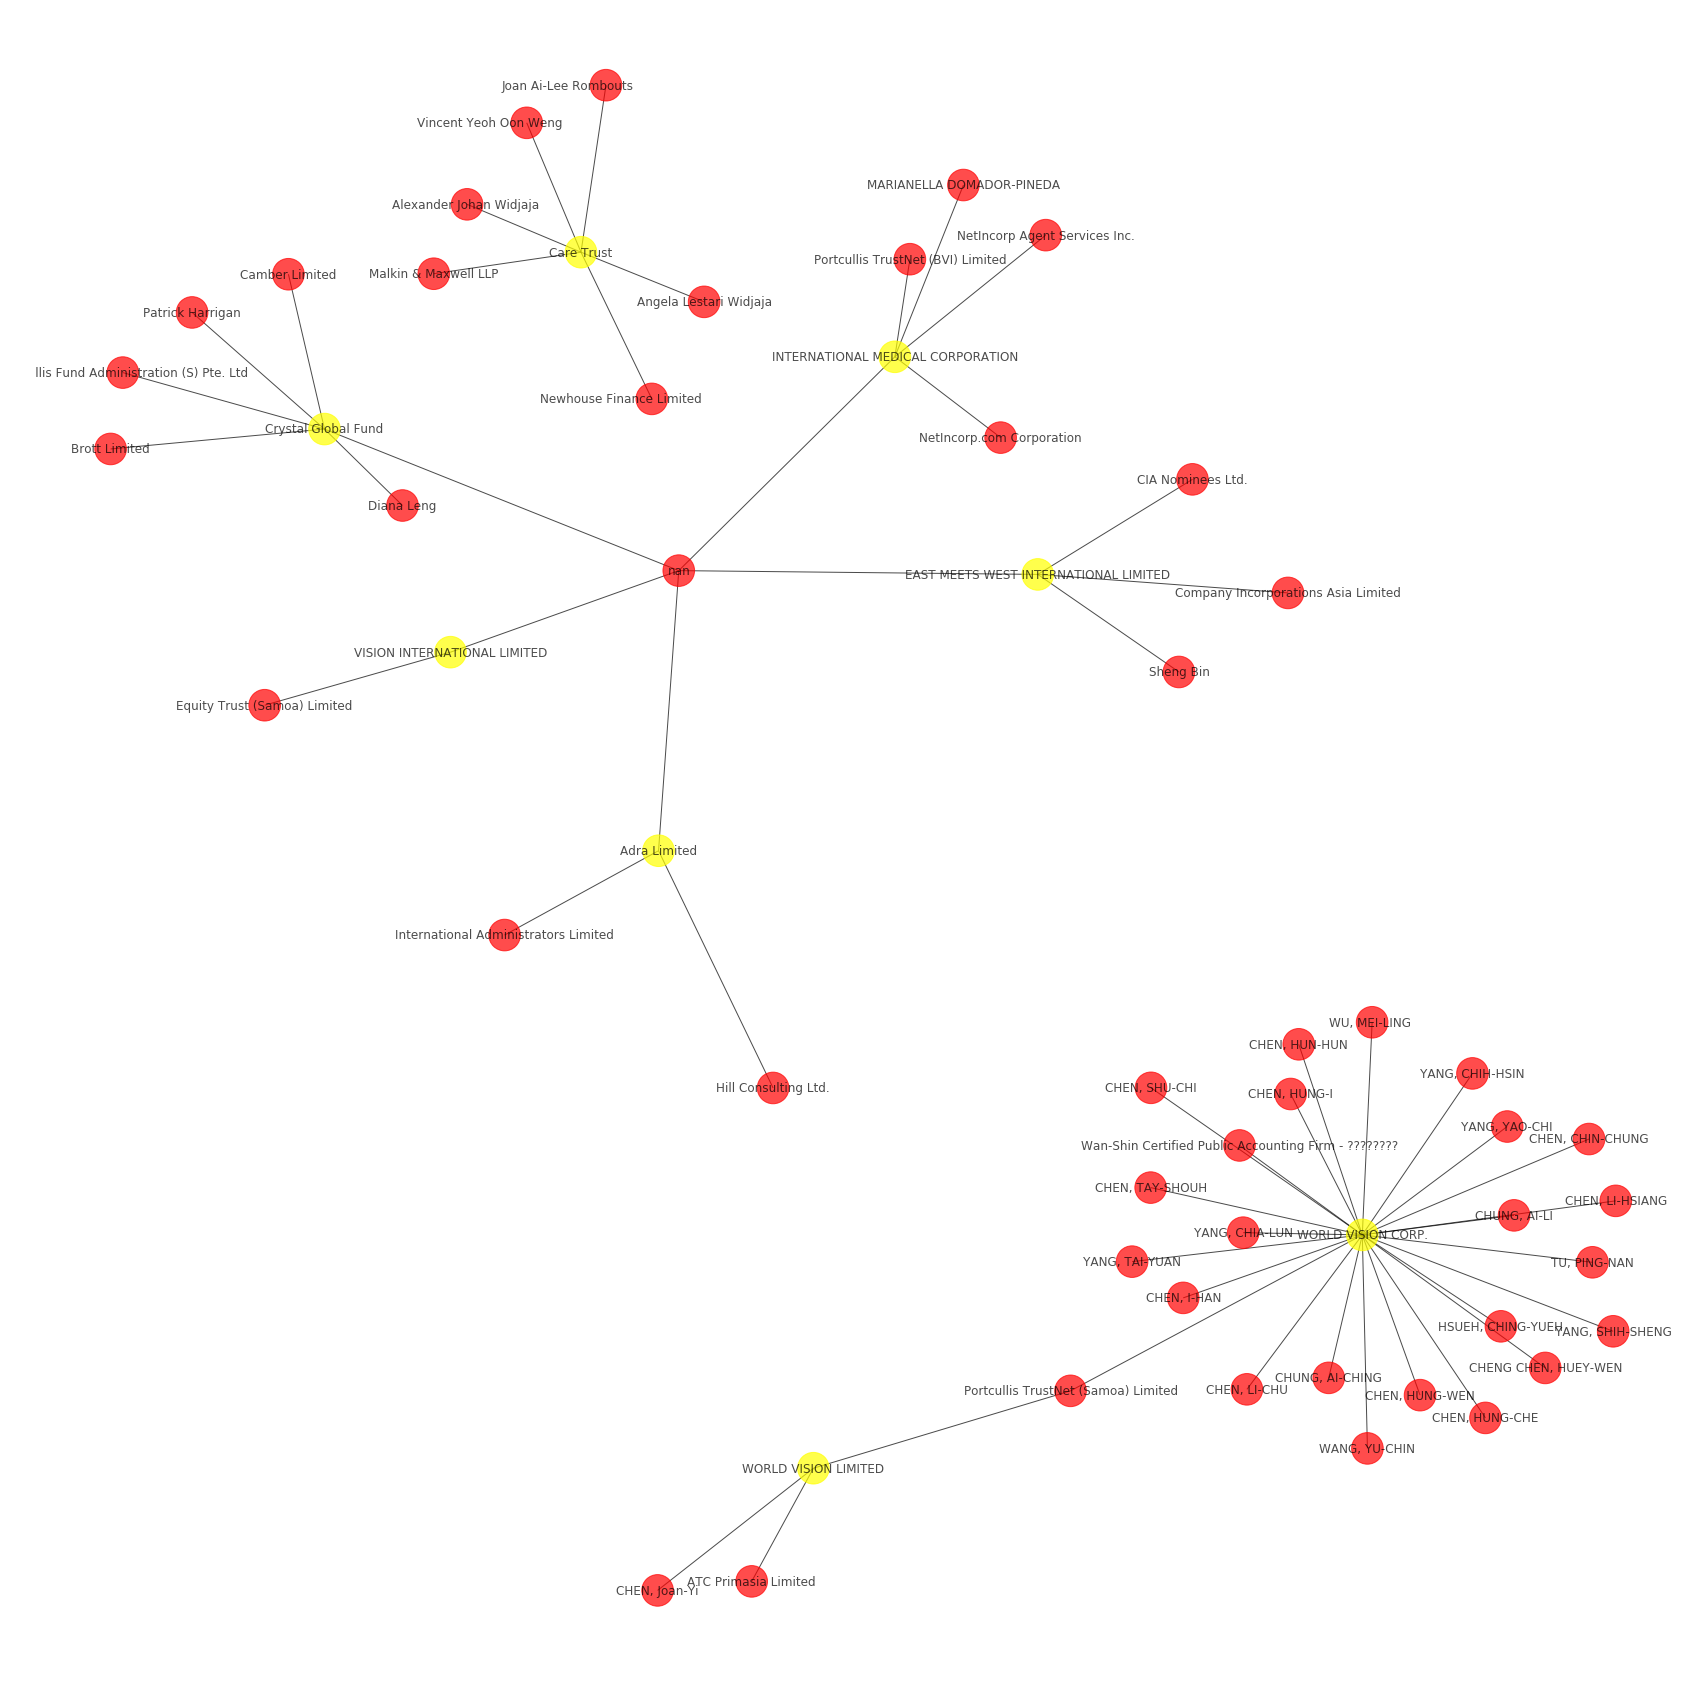

In [18]:
graph_leak_matches('offshore', True, True, 3)

Matches for bahamas papers: 
Name: 
Type: Graph
Number of nodes: 31
Number of edges: 19
Average degree:   1.2258


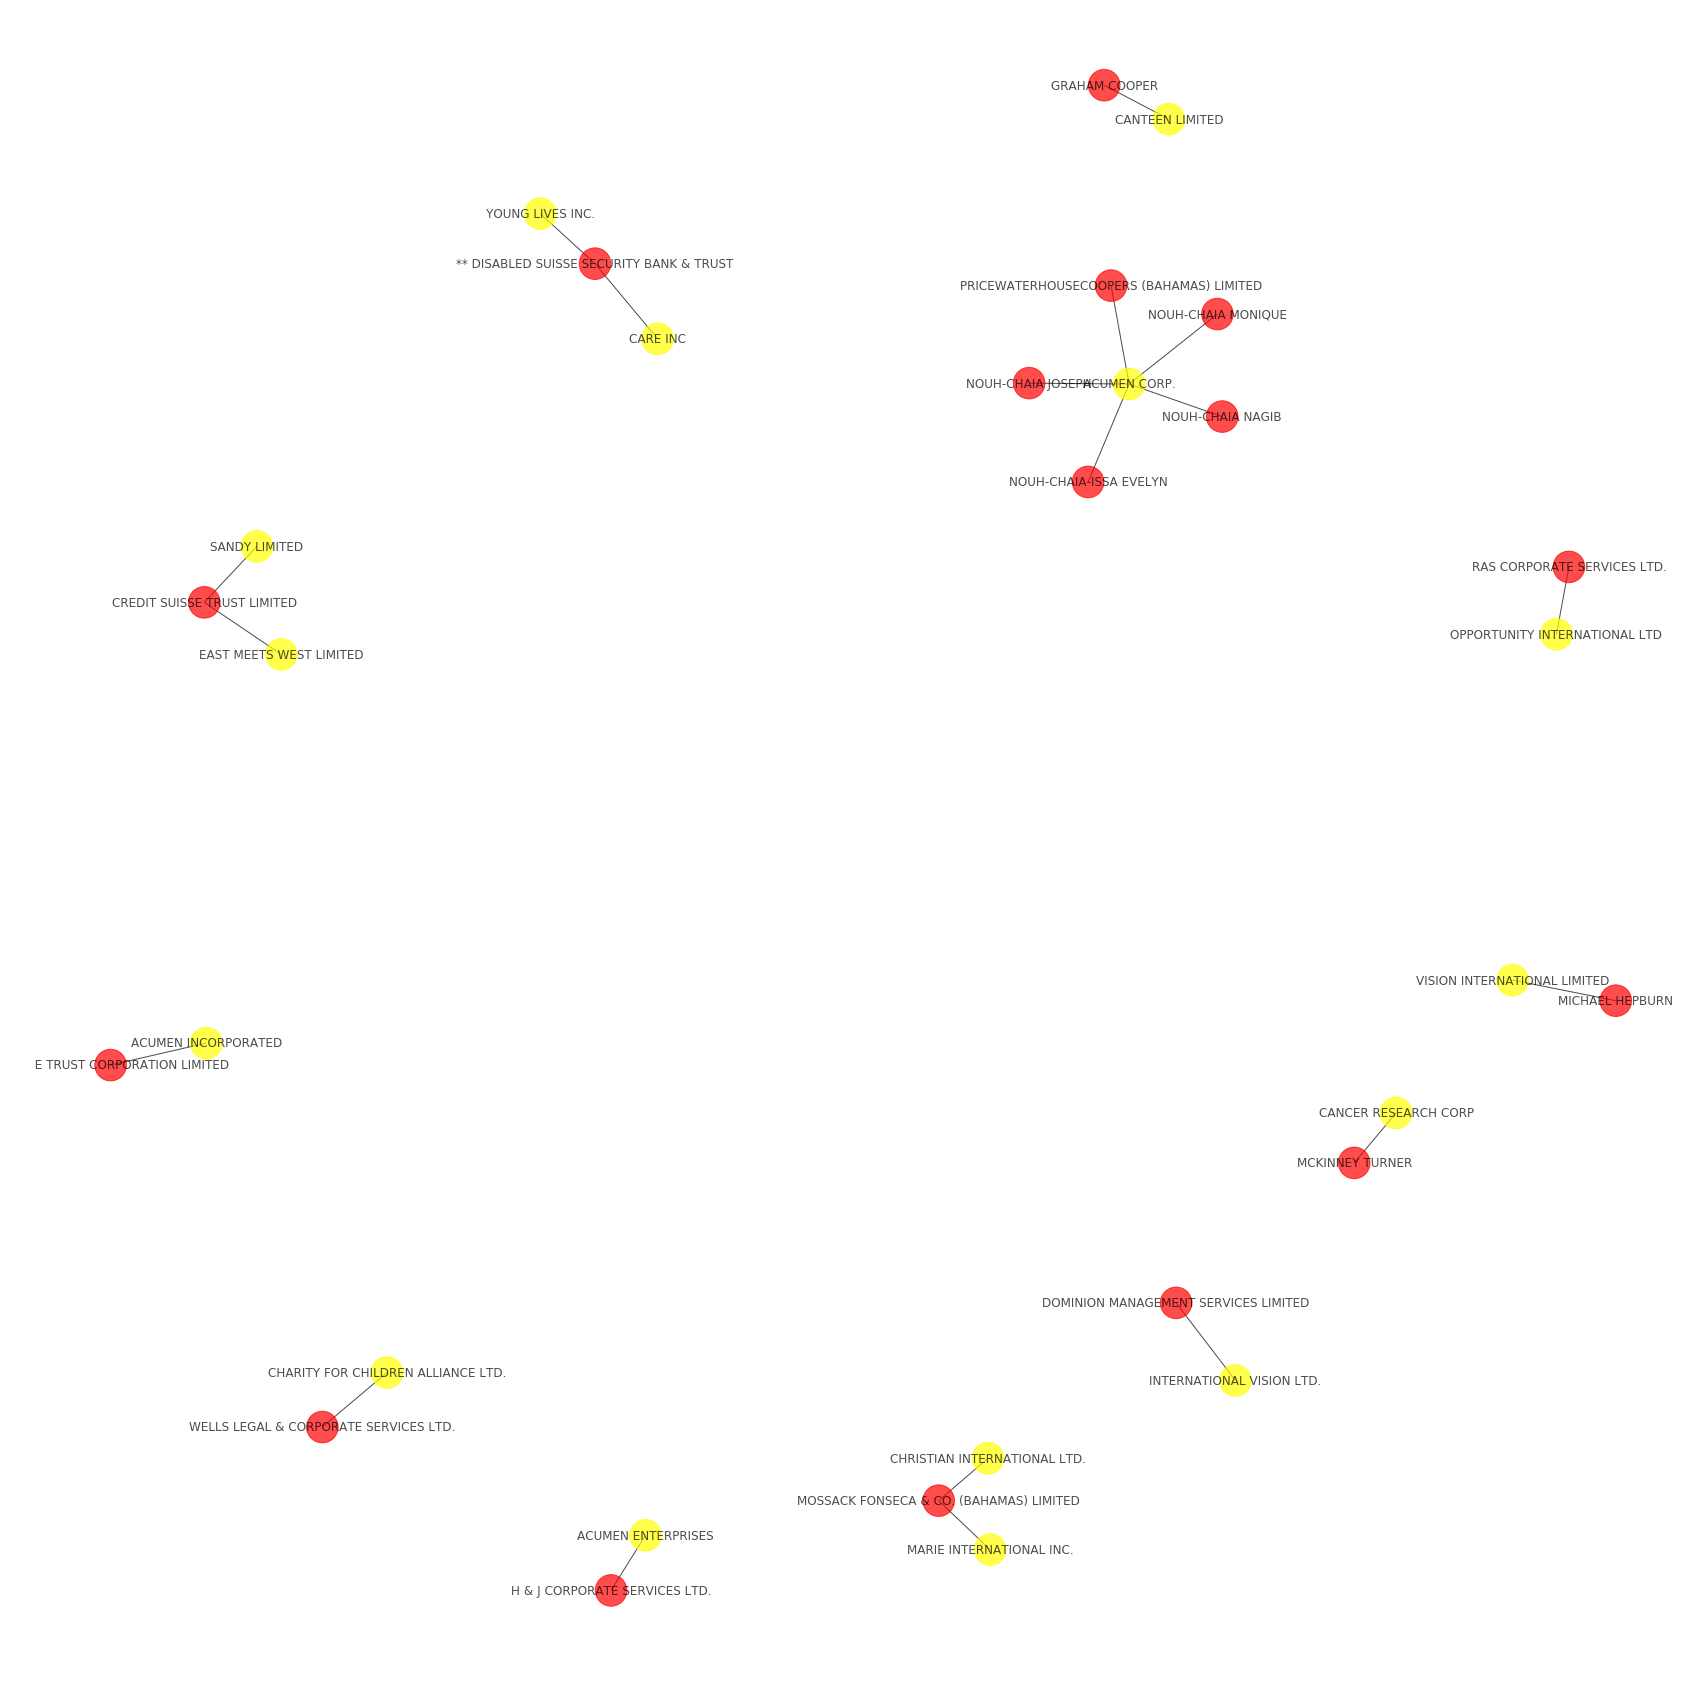

In [19]:
graph_leak_matches('bahamas')

Size before removing loners: 20
Size after removing loners: 6
Matches for bahamas papers: 
Name: 
Type: Graph
Number of nodes: 9
Number of edges: 6
Average degree:   1.3333


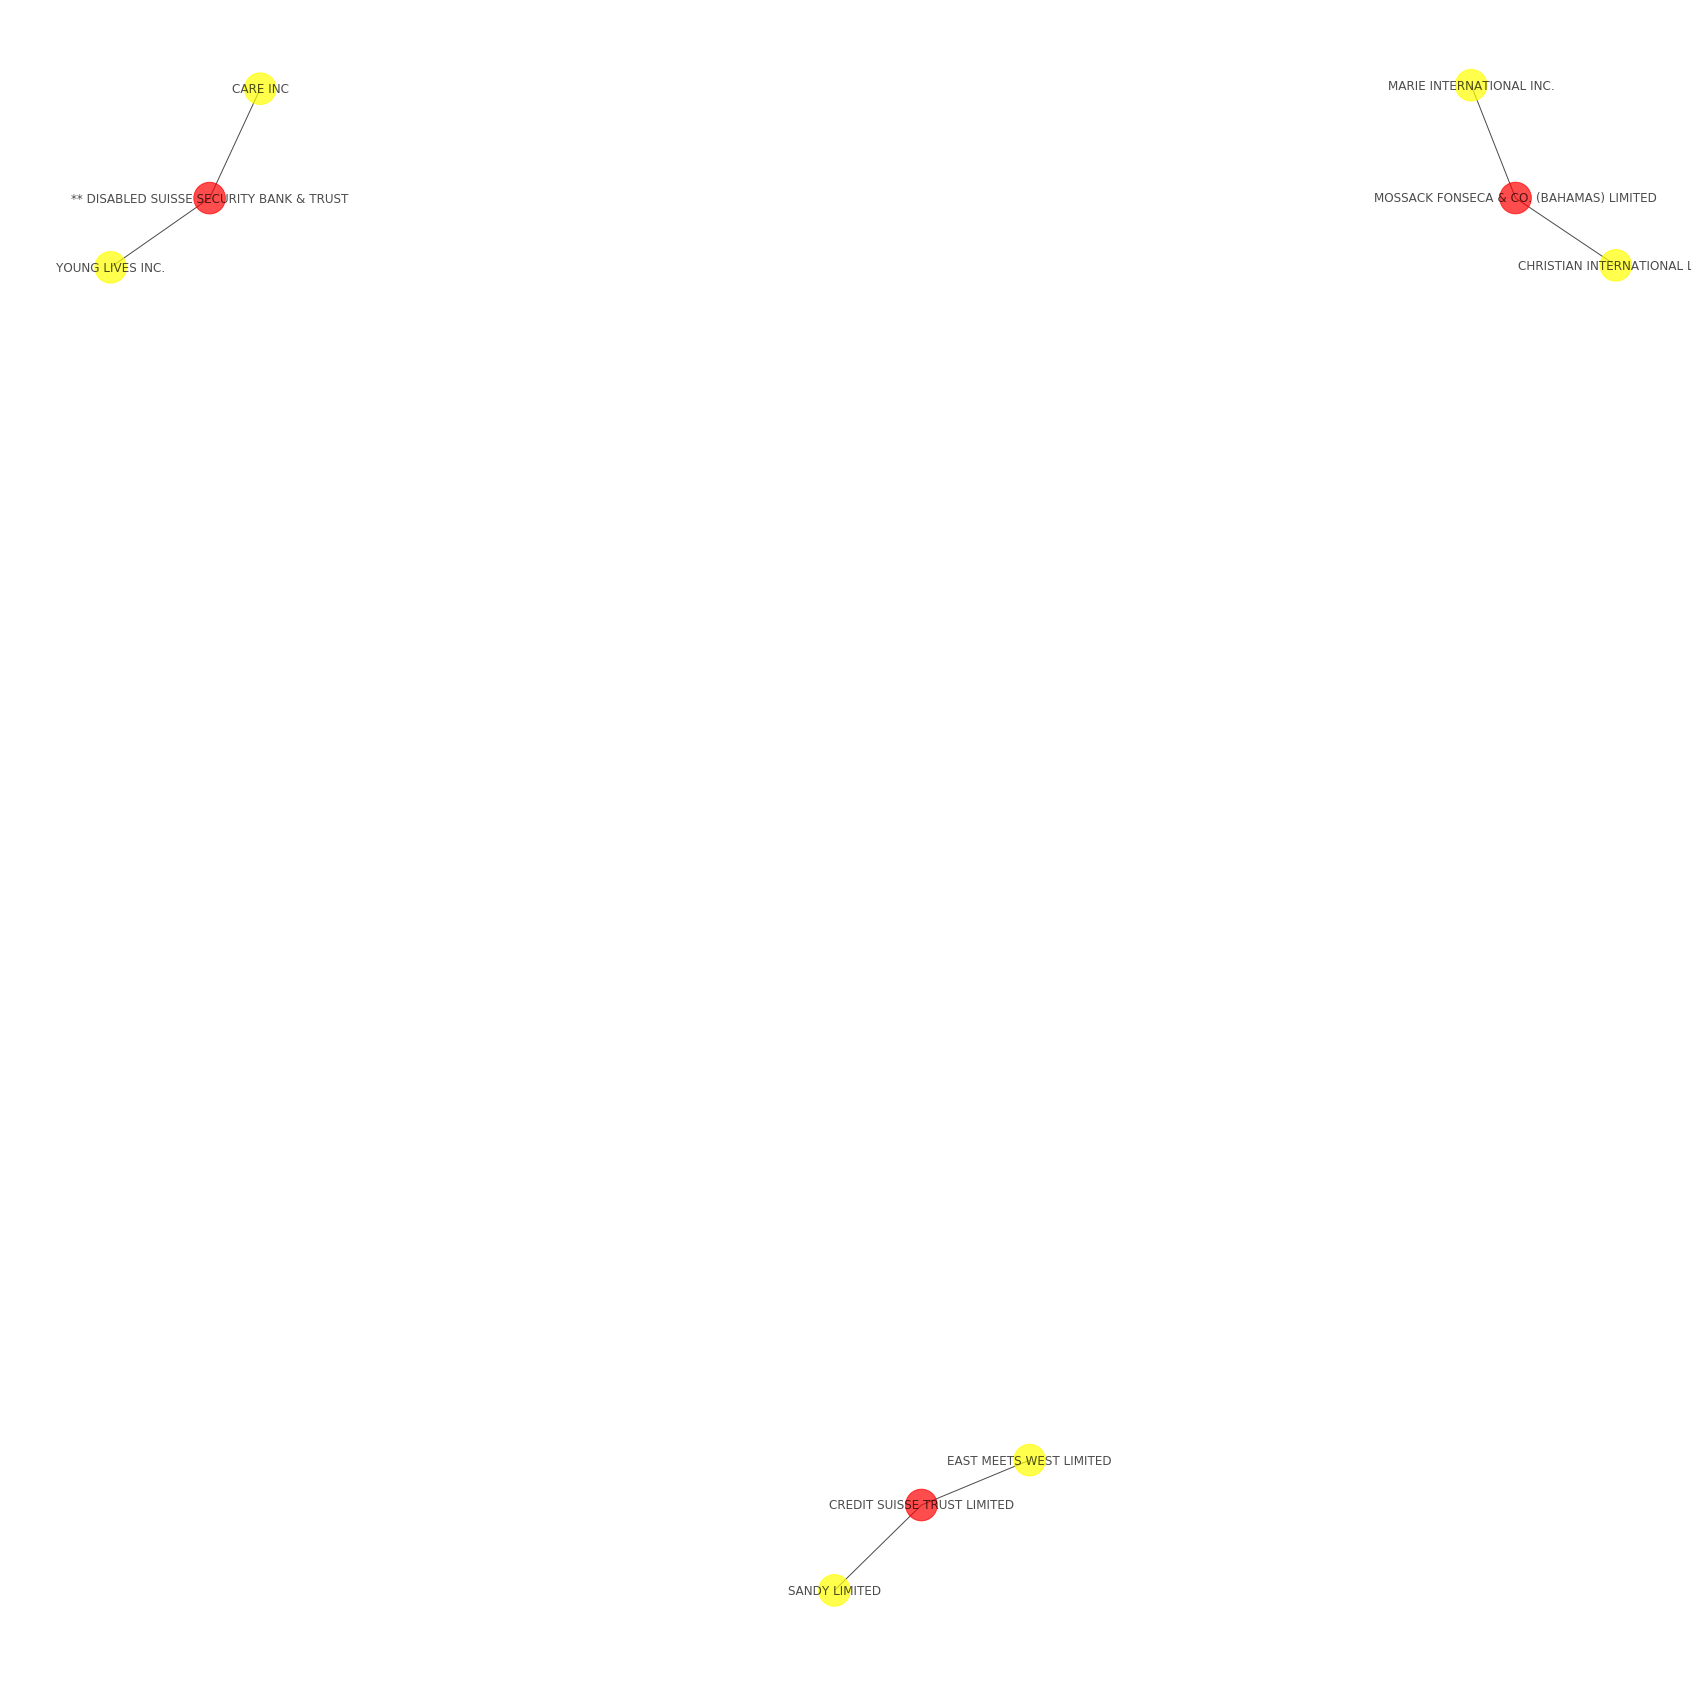

In [20]:
graph_leak_matches('bahamas', True)

Size before removing loners: 20
Size after removing loners: 12
Matches for bahamas papers: 
Name: 
Type: Graph
Number of nodes: 15
Number of edges: 11
Average degree:   1.4667


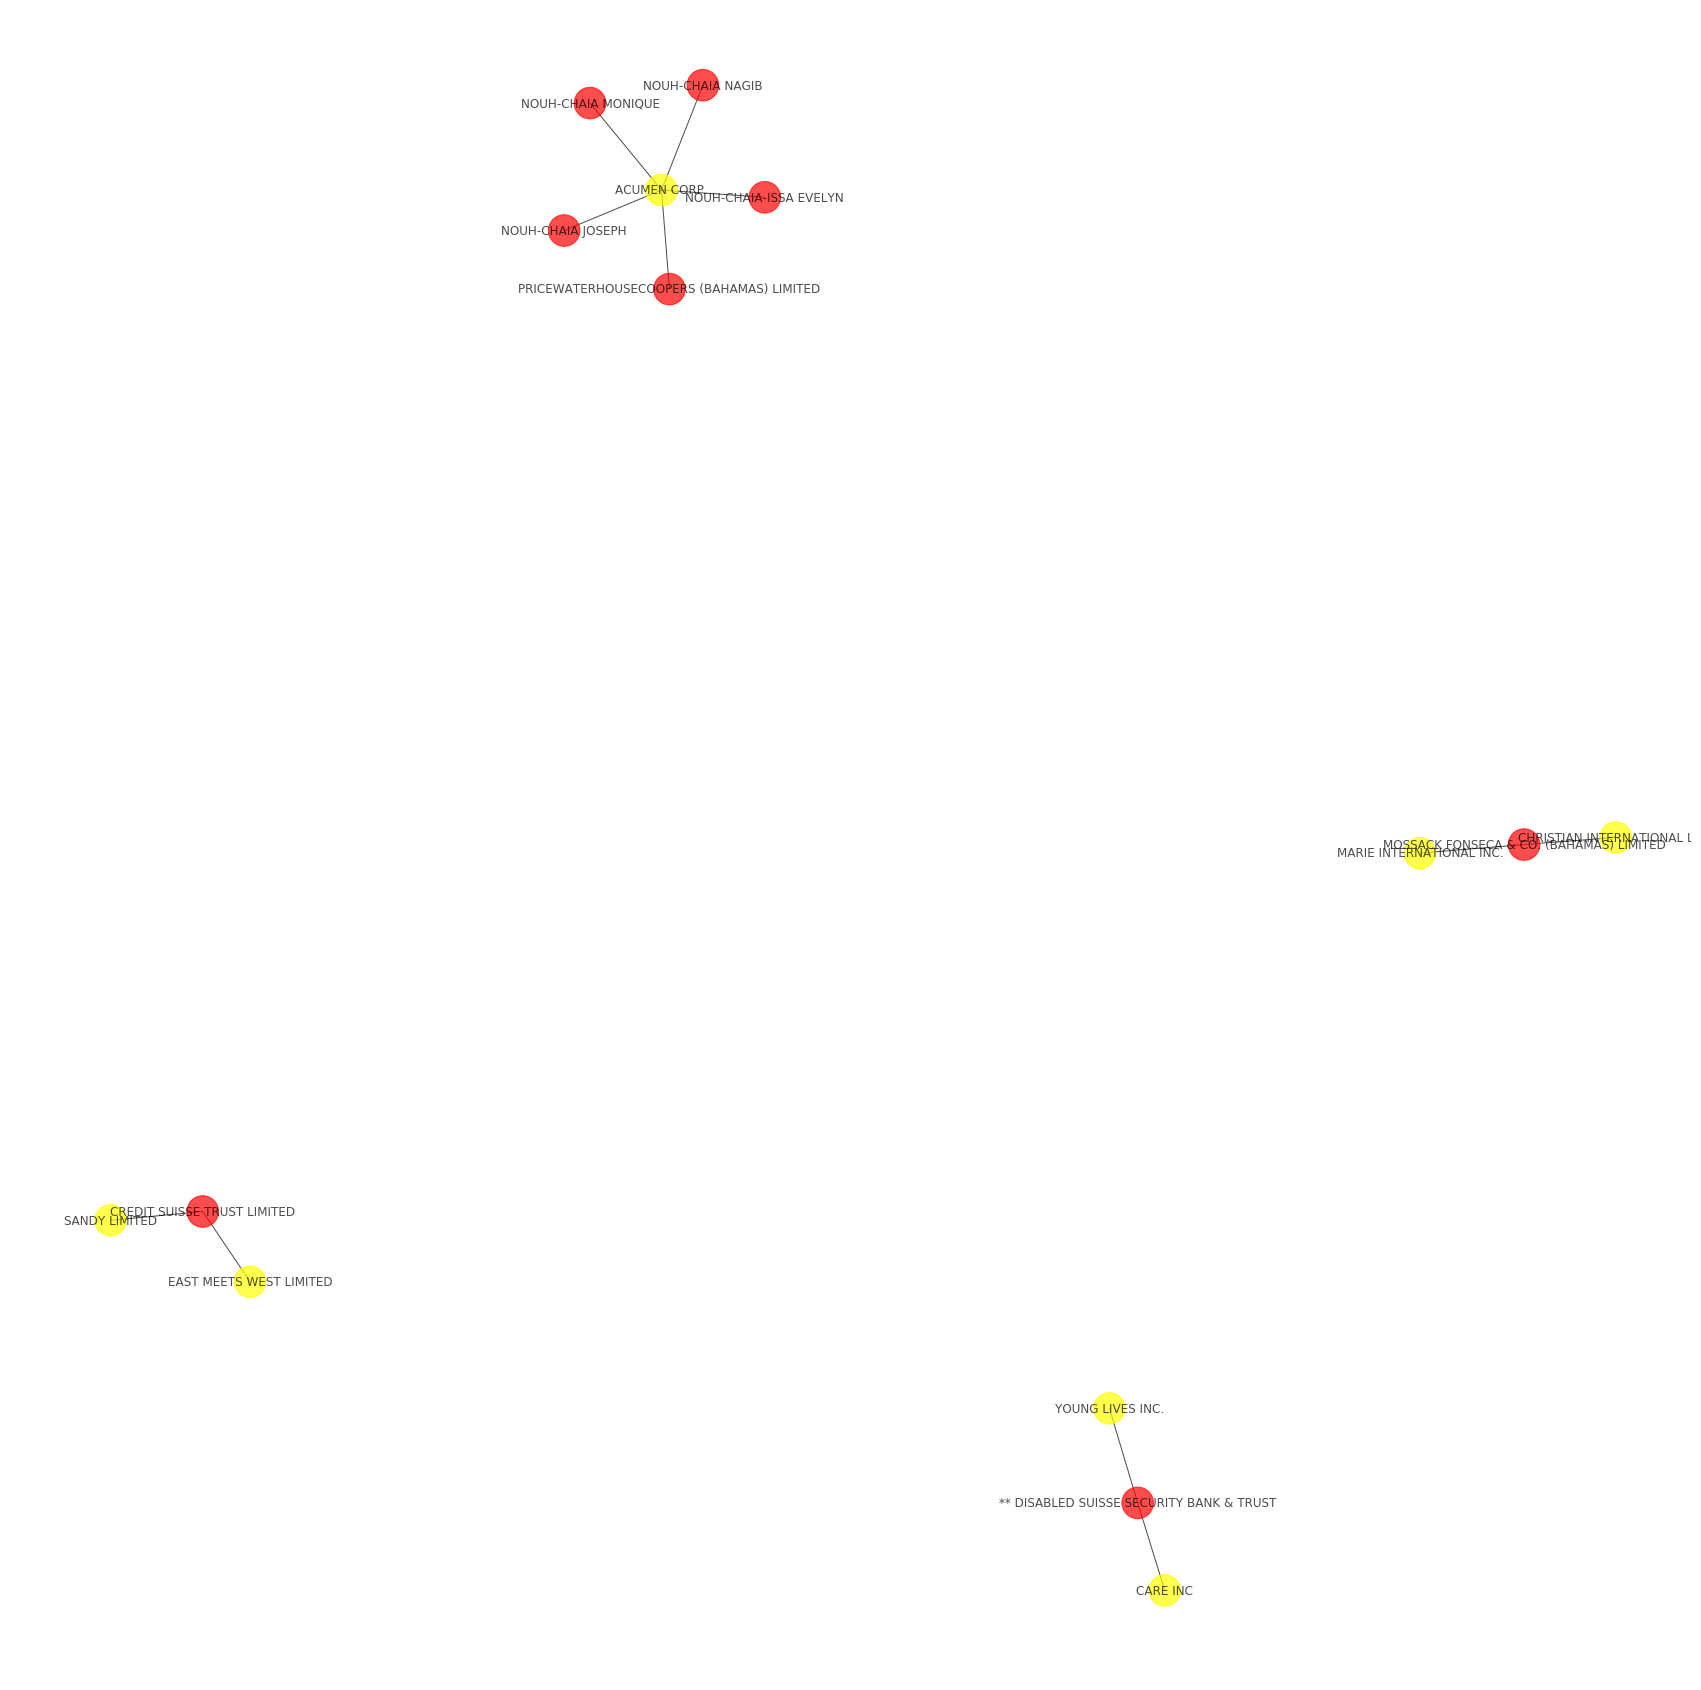

In [21]:
graph_leak_matches('bahamas', True, True)